**Appendix: Code**

Studying the relationship between investment amount and exit value for each company. 

Simulate the investment amount and exit value for 20 companies and find out the earliest stopping time when the total payoff (mDPI) of the fund reaches a certain level. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import seaborn as sns
import statsmodels.formula.api as sm
from scipy.stats import pearsonr
from distfit import distfit
import scipy
from scipy.interpolate import make_interp_spline
from scipy.stats import norm
import yahoo_fin.stock_info as si

# Apply the default theme
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mark Portfolio optimization

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt import objective_functions

### PE Lifetime Cash flow plot

In [2]:
year_time = np.arange(13)
contribution = np.array([1.606,22.892,48.333,22.892,4.277,0,0,0,0,0,0,0,0])
disturbution = np.array([0,0,0,17.477,73.372,0,0,7.989,16.767,11.384,0,0,4.502])

In [4]:
return_on_cash = np.insert((np.cumsum(disturbution) - np.cumsum(contribution))/np.cumsum(contribution),0,0)
year_time = np.arange(14)

In [5]:
X_Y_Spline = make_interp_spline(year_time, return_on_cash)
X_ = np.linspace(year_time.min(), year_time.max(), 500)
Y_ = X_Y_Spline(X_)

[Text(0.5, 0, 'Time(years)'), Text(0, 0.5, 'Return on Cash')]

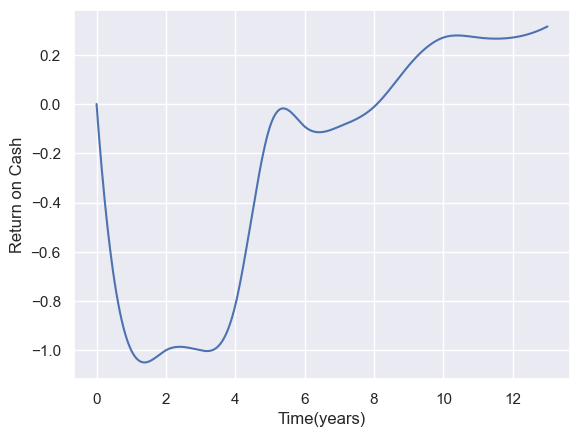

In [6]:
gfg = sns.lineplot(x=X_,y=Y_)
gfg.set(xlabel ="Time(years)", ylabel = "Return on Cash")

### Portfolio Optimization for stock

https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9

#### Read date

In [8]:
sp500_ticker_list = si.tickers_sp500()

In [13]:
def all_stocks_df(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        try:
            df[ticker] = si.get_data(ticker,start_date = '01/01/2016',end_date ='31/12/2020').adjclose
        except:
            print(ticker,'date not avaliable')
            tickers.remove(ticker)
    drop_nan_columns = df.columns[df.isnull().sum() > 10]
    df.drop(drop_nan_columns,axis=1,inplace=True)
    
    return df,df.columns

In [14]:
df_stocks_all,sp500_ticker_list_avaliable = all_stocks_df(sp500_ticker_list)

CEG date not avaliable
GEHC date not avaliable
OGN date not avaliable


In [15]:
def random_stocks20(sp500_ticker_list_avaliable):
    
    rand_ticker_num = np.random.randint(len(sp500_ticker_list_avaliable)-1, size=20)
    rand_tciker_name = []
    df_stocks = pd.DataFrame()
    for i in rand_ticker_num:
        df_stocks[sp500_ticker_list_avaliable[i]] = si.get_data(sp500_ticker_list_avaliable[i],start_date = '01/01/2015',end_date ='31/12/2019').adjclose
    return df_stocks

In [17]:
df_stocks = random_stocks20(sp500_ticker_list_avaliable)
df_stocks.head()

,PEP,COST,PFG,UAL,KEY,NWL,ILMN,ED,BRK-B,DAL,KEYS,VZ,MTCH,CTAS,DLTR,NRG,BALL,WBD,TMO,TXT
2015-01-02,74.949646,118.713036,38.622551,66.339996,10.642365,28.253628,185.419998,48.861958,149.169998,44.267323,33.419998,32.017189,16.062708,71.801079,70.349998,22.992834,31.866196,34.480000,125.031227,41.624718
2015-01-05,74.386162,117.363350,37.355251,66.150002,10.319871,27.925266,190.720001,48.397945,147.000000,43.529228,33.540001,31.751280,15.969473,70.492287,69.620003,22.114929,31.171118,33.060001,123.313698,40.825188
2015-01-06,73.822701,118.914246,36.825981,64.580002,10.005052,27.440201,188.309998,48.670471,146.839996,42.503117,33.610001,32.071724,16.028076,70.355011,68.669998,21.830647,30.643984,31.980000,122.162125,40.647507
2015-01-07,75.981323,120.984894,37.459621,65.529999,10.081836,27.604378,194.919998,49.392277,148.880005,42.278088,33.880001,31.864775,15.998775,69.988914,70.830002,21.930986,30.914543,32.209999,125.821747,40.914017
2015-01-08,77.362228,122.024368,38.562916,66.639999,10.289155,28.246157,196.820007,49.701618,151.369995,43.376213,34.119999,32.547729,16.390352,71.142113,71.110001,22.415918,31.446346,32.470001,127.129433,42.759834


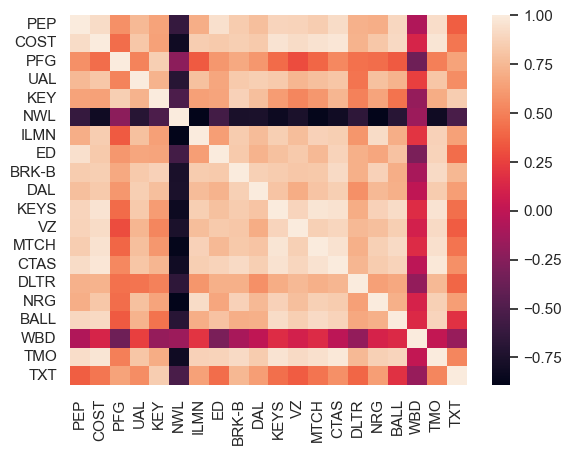

In [18]:
corr_matirx_stocks = df_stocks.corr()
sns.heatmap(corr_matirx_stocks)
plt.show()

#### Only for test

In [21]:
df_stock_logre = np.log(df_stocks) - np.log(df_stocks.shift(1))
df_stock_logre.dropna(axis=0,inplace=True)

In [22]:
current_window_vol = df_stock_logre.std()/np.sqrt(1/252)
current_window_corr = df_stock_logre.corr()/np.sqrt(1/252)
current_window_mu = df_stock_logre.mean()*252 + 0.5*current_window_vol**2

In [40]:
df_stocks.columns

Index(['PEP', 'COST', 'PFG', 'UAL', 'KEY', 'NWL', 'ILMN', 'ED', 'BRK-B', 'DAL',
       'KEYS', 'VZ', 'MTCH', 'CTAS', 'DLTR', 'NRG', 'BALL', 'WBD', 'TMO',
       'TXT'],
      dtype='object')

In [71]:
def stock_pred_df_corr(current_window_price):

    df_stock_logre = np.log(current_window_price) - np.log(current_window_price.shift(1))
    df_stock_logre.dropna(axis=0,inplace=True)
    
    current_window_vol = df_stock_logre.std()/np.sqrt(1/252)
    
    current_window_mu = df_stock_logre.mean()*252 + 0.5*current_window_vol**2
    
    current_window_corr = df_stock_logre.corr()
    L = np.linalg.cholesky(current_window_corr)
        
    increment = pd.DataFrame()
    for i in current_window_mu.index:
        mu = current_window_mu[i]
        sigma = current_window_vol[i]
        dt = 1/12/21
        size = 21
        increment[i] = (mu -  sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)
    
    
    df_pred = pd.DataFrame()
    for i,path in enumerate(np.dot(L,increment.values.T)):
        df_pred[df_stock_logre.columns[i]] = np.exp(path.cumsum())*current_window_price.iloc[-1,i]
        
        # print('last year last value',current_window_price[i][-1],'New year first prediction',stock_path[i][0])

    return df_pred

In [72]:
df_pred = stock_pred_df_corr(df_stocks)
df_pred

,PEP,COST,PFG,UAL,KEY,NWL,ILMN,ED,BRK-B,DAL,KEYS,VZ,MTCH,CTAS,DLTR,NRG,BALL,WBD,TMO,TXT
0,125.302649,286.650354,50.064378,92.145687,18.323450,17.452137,330.218003,78.800965,235.366463,60.521189,103.924773,52.626587,87.353812,260.631589,94.435854,34.411428,64.576343,33.402142,331.002662,45.782858
1,124.833704,285.457489,50.007813,93.319294,18.460732,16.637222,345.309337,78.819795,232.830134,60.507387,105.913231,51.871021,84.436164,255.604016,93.773628,34.632988,63.708710,33.811663,337.915955,44.953599
2,126.167936,283.731599,51.544553,95.629443,18.802490,17.375753,344.501675,79.477877,237.247200,62.207786,105.281165,52.746337,84.593116,261.671132,94.225182,36.008775,64.875062,34.712521,347.785318,44.784024
3,125.682985,278.196067,50.621955,93.932406,18.614843,17.220886,330.421284,79.691403,232.935686,60.969413,104.153033,52.575358,85.168596,260.482808,94.302417,34.509934,63.500070,34.673416,336.720590,44.189409
4,126.716601,279.931667,50.792863,94.168658,18.328952,17.615475,346.498137,80.505675,234.155861,62.001307,102.815578,52.402312,85.252584,258.798989,95.694593,35.095251,64.415447,35.370198,340.231649,44.017804
5,127.403162,281.503252,52.274826,97.367701,18.833388,17.602333,345.664884,79.232957,239.012741,63.379144,108.325848,52.431226,83.255119,265.648968,95.131222,34.215433,65.436454,35.998985,345.471664,44.743347
6,127.589221,284.467955,52.986046,96.990465,18.629104,17.627401,359.552273,79.036773,240.239660,63.631333,110.397372,52.089388,83.683372,272.636813,96.026454,35.335118,67.038745,36.816883,346.973479,45.502268
7,126.346997,283.759621,52.923485,95.621662,18.392000,17.442449,356.030511,79.070971,238.420662,62.806736,109.691061,52.067879,86.228723,271.075591,97.205997,35.521476,67.019248,36.473048,341.476258,45.763061
8,125.824851,282.208330,52.539494,95.471863,17.996687,16.843328,359.972123,79.201903,235.422427,62.751563,108.574100,51.548296,90.617071,273.444219,96.156882,36.013421,66.719903,36.477156,341.468370,45.037404
9,125.660179,281.329459,52.609365,97.406133,17.613025,17.099950,358.768927,80.444387,234.786496,63.175671,109.285014,51.792683,91.784062,268.941999,93.926929,35.615918,66.615164,36.419949,340.629398,44.734492


In [60]:
df_pred = pd.DataFrame()
for i,path in enumerate(np.dot(l,x.T)):
    df_pred[df_stocks.columns[i]] = np.exp(path.cumsum())*df_stocks.iloc[-1,i]


In [62]:
df_stocks.tail()

,PEP,COST,PFG,UAL,KEY,NWL,ILMN,ED,BRK-B,DAL,KEYS,VZ,MTCH,CTAS,DLTR,NRG,BALL,WBD,TMO,TXT
2019-12-23,126.008095,278.915192,48.508213,89.440002,17.838409,16.770292,334.019989,79.426895,225.479996,59.032059,103.959999,52.529839,80.180000,262.226898,92.440002,35.731377,63.479504,32.900002,325.876526,45.363247
2019-12-24,125.870193,279.789978,48.446247,89.150002,17.926500,16.813650,335.489990,79.329567,225.470001,58.982403,103.220001,52.427166,80.940002,260.242218,93.230003,35.561985,63.460052,33.029999,324.356628,44.835651
2019-12-26,125.686279,281.216400,48.667580,89.260002,17.944118,16.553511,331.339996,79.311905,226.449997,59.151237,103.650002,52.435730,82.510002,259.583923,92.080002,34.973587,63.148731,33.279999,323.561890,44.845604
2019-12-27,126.467850,279.675842,48.481655,88.370003,17.864838,16.674906,332.290009,79.568443,226.139999,58.674534,103.230003,52.641056,84.029999,260.435883,92.839996,34.973587,62.934708,33.130001,324.396332,44.158733
2019-12-30,125.796616,280.655396,48.384266,87.959999,17.811983,16.579525,328.140015,79.789612,225.759995,58.257412,102.180000,52.367279,82.980003,259.806549,93.489998,34.973587,62.691486,32.759998,322.896301,44.288147


In [61]:
df_pred.head()

,PEP,COST,PFG,UAL,KEY,NWL,ILMN,ED,BRK-B,DAL,KEYS,VZ,MTCH,CTAS,DLTR,NRG,BALL,WBD,TMO,TXT
0,126.399313,279.277513,48.194465,84.292235,17.659077,16.726681,332.712838,81.060273,223.932047,56.876535,104.043436,52.307978,84.577575,262.807081,91.345782,35.906201,63.325748,32.564465,330.293515,44.199558
1,126.896767,275.244681,46.578243,80.879234,16.926315,16.504697,341.066341,80.943012,219.682817,54.141558,102.102372,51.431149,82.144966,260.595969,90.726885,36.127029,63.881702,31.999008,327.921928,42.466240
2,125.727487,280.459364,47.084270,82.645520,17.019667,16.342433,352.116186,80.017719,222.327717,55.848319,101.753298,50.655598,81.372578,266.142012,91.110308,34.850528,63.409052,32.195799,326.842453,43.101716
3,124.940053,284.134150,46.797382,81.998334,17.037747,16.859750,352.763180,79.424907,221.107992,55.779555,100.061817,50.618368,78.439621,264.725328,90.833978,33.922829,64.844730,32.998915,325.052107,43.106497
4,125.973200,284.853770,45.972901,78.834159,16.820196,17.214822,356.980057,80.077216,218.178708,55.024093,95.619563,50.540513,82.120959,265.976057,89.710119,34.680515,65.787993,32.484627,320.574008,43.171547


In [29]:
def stock_pred_df(current_window_price):

    df_stock_logre = np.log(current_window_price) - np.log(current_window_price.shift(1))
    df_stock_logre.dropna(axis=0,inplace=True)
    
    current_window_vol = df_stock_logre.std()/np.sqrt(1/252)
    
    current_window_mu = df_stock_logre.mean()*252 + 0.5*current_window_vol**2
    
        
    stock_path = pd.DataFrame()
    for i in current_window_mu.index:
        mu = current_window_mu[i]
        sigma = current_window_vol[i]
        dt = 1/12/21
        size = 21
        stock_path[i] = np.exp(np.cumsum(((mu -  sigma**2/2)*dt + \
                                                   sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0))*current_window_price[i][-1]
        
        # print('last year last value',current_window_price[i][-1],'New year first prediction',stock_path[i][0])

    return stock_path 

In [78]:
de_pred = pd.DataFrame()
for i in range(12):
    df_pred_onemonth = stock_pred_df(df_stocks.iloc[12*i:(252+12*i)])
    de_pred = pd.concat([de_pred,df_pred_onemonth])
de_pred.reset_index(drop=True, inplace=True)

<AxesSubplot: >

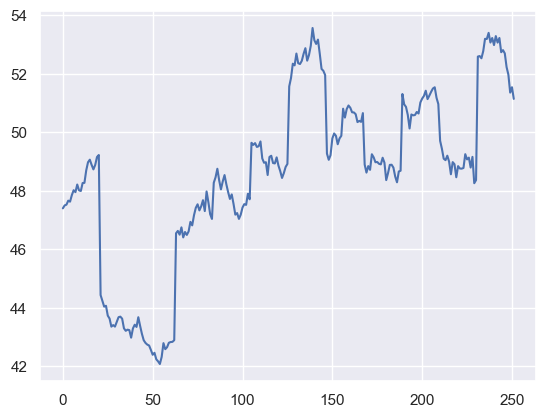

In [88]:
de_pred.mean(axis=1).plot()

In [38]:
scipy.stats.poisson.rvs(1, size=20)

array([2, 1, 3, 0, 2, 0, 3, 0, 0, 1, 0, 2, 1, 1, 0, 3, 0, 2, 2, 2],
      dtype=int64)

#### SIAM for stock

In [11]:
# Only run one time!!!!!!!
df_stocks.drop(df_stocks.index[0] ,inplace=True)

In [12]:
# Validation idea
class SIAM_validate_stock():
    def __init__(self, start_year= 0 ,df_stocks_price = df_stocks, K=10, Max_length_month = 20, Expacted_logreturn= 0.01,lamda_exit = 5):
        self.start_year = start_year
        self.df_stocks_price_select = df_stocks_price.iloc[start_year*252:] #number of companies
        self.I = df_stocks_price.shape[1]
        self.K = K #number of iterations
        self.Max_length_month = Max_length_month 
        self.Expacted_logreturn = Expacted_logreturn
        self.lamda_exit = lamda_exit 
        
    def simu_k_scenairos(self):
        completion_time_Ktimes = []

        for k in range(self.K):
            completion_time = scipy.stats.poisson.rvs(self.lamda_exit, size=self.I)
            completion_time_Ktimes.append(completion_time)
        
        completion_time_Ktimes = np.array(completion_time_Ktimes)
        
        return completion_time_Ktimes
    
    # def calculate_return_df(self):
    #     df_stocks_return = np.log(self.df_stocks_price_select) - np.log(self.df_stocks_price_select.shift(1))
    #     df_stocks_return.dropna(axis=0,inplace = True)
        
    #     return df_stocks_return
    

    def stock_pred_df(self,current_window_price):

        df_stock_logre = np.log(current_window_price) - np.log(current_window_price.shift(1))
        df_stock_logre.dropna(axis=0,inplace=True)
        
        current_window_vol = df_stock_logre.std()/np.sqrt(1/252)
        current_window_mu = df_stock_logre.mean()*252 + 0.5*current_window_vol**2
            
        stock_path = pd.DataFrame()
        for i in current_window_mu.index:
            mu = current_window_mu[i]
            sigma = current_window_vol[i]
            dt = 1/12/21
            size = 21
            stock_path[i] = np.exp(np.cumsum(((mu -  sigma**2/2)*dt + \
                                                    sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0))*current_window_price[i][-1]

        return stock_path 
    
    def stock_pred_df_corr(self,current_window_price):

        df_stock_logre = np.log(current_window_price) - np.log(current_window_price.shift(1))
        df_stock_logre.dropna(axis=0,inplace=True)
        
        current_window_vol = df_stock_logre.std()/np.sqrt(1/252)
        
        current_window_mu = df_stock_logre.mean()*252 + 0.5*current_window_vol**2
        
        current_window_corr = df_stock_logre.corr()
        L = np.linalg.cholesky(current_window_corr)
            
        increment = pd.DataFrame()
        for i in current_window_mu.index:
            mu = current_window_mu[i]
            sigma = current_window_vol[i]
            dt = 1/12/21
            size = 21
            increment[i] = (mu -  sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)
        
        
        df_pred = pd.DataFrame()
        for i,path in enumerate(np.dot(L,increment.values.T)):
            df_pred[df_stock_logre.columns[i]] = np.exp(path.cumsum())*current_window_price.iloc[-1,i]
            
            # print('last year last value',current_window_price[i][-1],'New year first prediction',stock_path[i][0])

        return df_pred
      
    
    def port_maxi(self,current_window_stock_price):
    
        #Annualized Return
        mu = expected_returns.mean_historical_return(current_window_stock_price)
        #Sample Variance of Portfolio
        Sigma = risk_models.sample_cov(current_window_stock_price)

        ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
        ef.add_objective(objective_functions.L2_reg, gamma=1)
        sharpe_pfolio=ef.max_sharpe(risk_free_rate=0.005) #May use add objective to ensure minimum zero weighting to individual stocks
        sharpe_pwt=ef.clean_weights()
        
        return sharpe_pwt
    
    def SIAM_main(self):
             
        # Investment data
        
        investment_terminated_time_siam = np.zeros(self.K)
        investment_terminated_time_mark = np.zeros(self.K)
        investment_terminated_time_equalweight = np.zeros(self.K)

        for k in range(self.K):
            completion_time = scipy.stats.poisson.rvs(self.lamda_exit, size=self.I)
            max_exit_month = completion_time.max()

            sum_exit_return_siam = 0
            sum_exit_return_mark = 0
            sum_exit_return_equalweight = 0

            # Signal for whether this method in each simulation is finished
            signal_siam = 0
            signal_mark = 0
            signal_equal_weight = 0

            for t in range(max_exit_month):
                # stock data seen as historical 
                current_window_stocks = self.df_stocks_price_select.iloc[t*21:(t+12)*21]
                # current_window_return = df_stock_return.iloc[t*21:(t+12)*21]

                # Log return prediction for one month
                stock_pred_df = self.stock_pred_df(current_window_stocks)

                weight_df = self.port_maxi(current_window_stocks)

                # Weight calculated based on historical data * stock price prediction in one month
                if signal_mark == 0:
                    sum_exit_return_mark = np.sum( np.log((stock_pred_df.max()/ self.df_stocks_price_select.iloc[12*21,:]).values) * list(weight_df.values()))
                    # sum_exit_return_mark = np.sum( np.log((stock_pred_df.max()/ stock_pred_df.iloc[0,:]).values) * list(weight_df.values()))
                
                if signal_equal_weight == 0:
                    sum_exit_return_equalweight = np.mean(np.log((stock_pred_df.max()/ self.df_stocks_price_select.iloc[12*21,:]).values))
                    # print(sum_exit_return_equalweight,'sum_exit_return_equalweight','round',t,'simulation',k)

                # SIAM method 
                for company_i in range(self.I):
                    if (completion_time[company_i] == t) & (signal_siam == 0):
                        # Last prediction of the stock 
                        # log return for one company
                        max_price_onemonth = stock_pred_df.iloc[:,company_i].max()

                        # print( max_price_onemonth / self.df_stocks_price_select.iloc[12*21,company_i], 'is the log return for stock',company_i,'at time',t,'in simulation',k)

                        # sum_exit_return_siam = sum_exit_return_siam + np.log( stock_pred_df.iloc[-1,company_i] / self.df_stocks_price_select.iloc[12*21,company_i])/20 # df_stocks.iloc[12*21,:] is the investment t=0
                        sum_exit_return_siam = sum_exit_return_siam + np.log( max_price_onemonth / self.df_stocks_price_select.iloc[12*21,company_i])/20
                        # print('Simulation',k,'month',t,'return',sum_exit_return_siam,company_i,'exit')

                if (sum_exit_return_mark > self.Expacted_logreturn) & (signal_mark == 0):
                    investment_terminated_time_mark[k] = t + 1
                    signal_mark = 1
                    # print('Simulation',k,'exit at Round',t,'Success',sum_exit_return_mark)
                elif (t == max_exit_month-1) & (signal_mark == 0):
                    investment_terminated_time_mark[k] = np.nan
                    # print('Simulation',k,'exit at Round',t,'Failed',sum_exit_return_mark)

                
                if (sum_exit_return_siam > self.Expacted_logreturn) & (signal_siam == 0):
                    investment_terminated_time_siam[k] = t + 1
                    # print('Simulation',k,'exit at Round',t,'SIAM Success',sum_exit_return_siam)
                    signal_siam = 1
                    
                elif (t == max_exit_month-1) & (signal_siam == 0):
                    # print('Simulation',k,'exit at Round',t,'SIAM failed',sum_exit_return_siam)
                    investment_terminated_time_siam[k] = np.nan
                
                if (sum_exit_return_equalweight > self.Expacted_logreturn) & (signal_equal_weight == 0):
                    investment_terminated_time_equalweight[k] = t + 1
                    signal_equal_weight = 1
                elif (t == max_exit_month-1) & (signal_equal_weight == 0):
                    # print('Simulation',k,'exit at Round',t,'SIAM failed',sum_exit_return_siam)
                    investment_terminated_time_equalweight[k] = np.nan


        
        return np.nanmean(investment_terminated_time_mark),np.nanstd(investment_terminated_time_mark),(-np.isnan(investment_terminated_time_mark).sum()/self.K +1),np.nanmean(investment_terminated_time_siam),\
            np.nanstd(investment_terminated_time_siam),(-np.isnan(investment_terminated_time_siam).sum()/self.K + 1),np.nanmean(investment_terminated_time_equalweight),\
            np.nanstd(investment_terminated_time_equalweight),(-np.isnan(investment_terminated_time_equalweight).sum()/self.K +1)
    

In [14]:
SIAM_vali = SIAM_validate_stock(start_year= 0, K=100,Expacted_logreturn=0.05,lamda_exit = 5)
SIAM_vali.SIAM_main()

(1.33,
 0.7218725649309579,
 1.0,
 7.0625,
 1.2146029872623674,
 0.96,
 3.09,
 1.7151967817133986,
 1.0)

#### Actual Data vs SIMA vs Mark

Expected Reture $R^*$ measured by log return $\sum_{i \in I} \omega_{i} log \frac{W_{T,i}}{W_{0,i}}$

In [30]:
def actual_terminated_time(start_year,df_stocks):

    result_only_end_date = []
    result_all_date = []
    df_stocks_select = df_stocks.iloc[start_year*252:]

    for month in np.arange(12,12*3):

        result_only_end_date.append(np.log(df_stocks_select.iloc[month*21,:]/df_stocks_select.iloc[252,:]).mean())
        result_all_date.append(np.log(df_stocks_select.iloc[month*21:(month+1)*21,:].max()/df_stocks_select.iloc[252,:]).mean())
    return np.array(result_only_end_date),np.array(result_all_date)

In [31]:
# Actual Termianl time dataframe
expected_logreturn = np.array([0.03,0.05,0.07,0.09,0.11,0.13])
start_year = np.array([0,1,2])

actual_terminal_time = np.array([])

for year in start_year:

    flag = 0
    
    _,actual_return_alldate = actual_terminated_time(year,df_stocks)
    terminal_time = np.array([])
    
    for r in expected_logreturn:
        for count,logreturn in enumerate(actual_return_alldate):
            if logreturn > r:
                terminal_time = np.append(terminal_time,count+1)
                flag = 1
                # print('Year',year,'Expected r',r,'stop at',terminal_time)
                break
        if count + 1 == len(actual_return_alldate):
            terminal_time = np.append(terminal_time,np.nan)

    actual_terminal_time = np.append(actual_terminal_time,terminal_time)

     

In [37]:
mark_mean_list = []
mark_std_list = []
mark_nan_list= []
siam_mean_list = []
siam_std_list = []
siam_nan_list = []
equal_we_mean_list = []
equal_we_std_list = []
equal_weight_nan_list = []


for year in start_year:
    for r in expected_logreturn:
        SIAM_vali = SIAM_validate_stock(start_year= year, K=50,Expacted_logreturn= r ,lamda_exit = np.rint(r*60))
        mark_mean,mark_std,mark_nan,siam_mean,siam_std,siam_nan,equal_we_mean,equal_we_std,equal_weight_nan = SIAM_vali.SIAM_main()

        mark_mean_list.append(mark_mean)
        mark_std_list.append(mark_std)
        mark_nan_list.append(mark_nan)

        siam_mean_list.append(siam_mean)
        siam_std_list.append(siam_std)
        siam_nan_list.append(siam_nan)

        equal_we_mean_list.append(equal_we_mean)
        equal_we_std_list.append(equal_we_std)
        equal_weight_nan_list.append(equal_weight_nan)



In [39]:
start_year_rename = np.array(['2017','2018','2019'])
Compar_result_df = pd.DataFrame({'Expected Log Return':np.tile(expected_logreturn,len(start_year_rename)),
                                 'Start Year':np.repeat(start_year_rename,len(expected_logreturn)),
                                 'Actual Terminated Time':actual_terminal_time,
                                 'SIAM Mean':siam_mean_list,
                                 'SIAM Std':siam_std_list,
                                 'SIAM Success Rate':siam_nan_list,
                                 'Markowitz Mean':mark_mean_list,
                                 'Markowitz Std':mark_std_list,
                                 'Markowitz Success Rate':mark_nan_list,
                                 'Equal Weight Mean':equal_we_mean_list,
                                 'Equal Weight  Std':equal_we_std_list,
                                 'Equal Weight  Success Rate':equal_weight_nan_list,
                                 })

In [40]:
Compar_result_df

,Expected Log Return,Start Year,Actual Terminated Time,SIAM Mean,SIAM Std,SIAM Success Rate,Markowitz Mean,Markowitz Std,Markowitz Success Rate,Equal Weight Mean,Equal Weight Std,Equal Weight Success Rate
0,0.03,2017,3.0,4.400000,0.800000,0.10,1.12,0.474974,1.0,1.180000,0.712461,1.00
1,0.05,2017,4.0,5.923077,1.140954,0.26,1.40,0.824621,1.0,2.755102,1.755814,0.98
2,0.07,2017,4.0,7.333333,1.154701,0.36,1.98,1.208139,1.0,4.340000,1.632299,1.00
3,0.09,2017,6.0,7.961538,1.372274,0.52,2.92,1.278124,1.0,5.680000,0.507543,1.00
4,0.11,2017,7.0,9.666667,1.299573,0.90,3.32,1.271849,1.0,5.980000,0.140000,1.00
5,0.13,2017,7.0,11.086957,1.332309,0.92,3.76,1.175755,1.0,6.000000,0.000000,1.00
6,0.03,2018,1.0,2.480000,0.538145,1.00,1.10,0.300000,1.0,1.080000,0.271293,1.00
7,0.05,2018,2.0,3.840000,0.643739,1.00,1.20,0.400000,1.0,1.500000,0.500000,1.00
8,0.07,2018,2.0,4.959184,0.698663,0.98,1.18,0.384187,1.0,1.780000,0.414246,1.00
9,0.09,2018,4.0,6.560000,0.637495,1.00,1.32,0.466476,1.0,2.200000,0.400000,1.00


In [35]:
print(Compar_result_df.to_latex())

\begin{tabular}{lrlrrrrrrrrrr}
\toprule
{} &  Expected Log Return & Start Year &  Actual Terminated Time &  SIAM Mean &  SIAM Std &  SIAM Success Rate &  Markowitz Mean &  Markowitz Std &  Markowitz Success Rate &  Equal Weight Mean &  Equal Weight  Std &  Equal Weight  Success Rate \\
\midrule
0  &                 0.03 &       2017 &                     3.0 &   4.625000 &  0.695971 &               0.16 &            1.18 &       0.517301 &                     1.0 &               1.24 &           0.813880 &                         1.0 \\
1  &                 0.05 &       2017 &                     4.0 &   6.333333 &  0.881917 &               0.72 &            1.40 &       0.824621 &                     1.0 &               2.54 &           1.699529 &                         1.0 \\
2  &                 0.07 &       2017 &                     4.0 &   8.000000 &  1.010153 &               0.98 &            2.00 &       1.131371 &                     1.0 &               4.94 &           1.027

Text(0, 0.5, 'SIAM terminal time for the portfoilo')

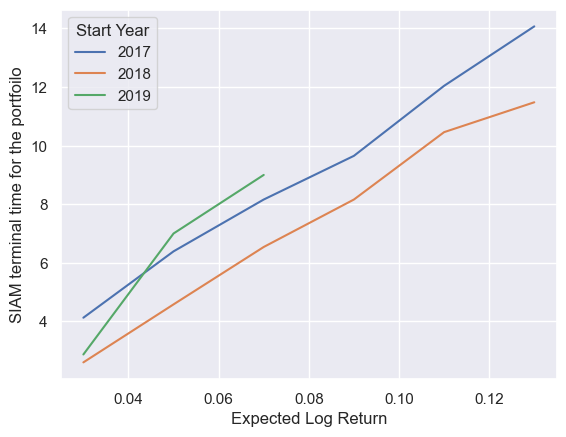

In [67]:
sns.lineplot(data = Compar_result_df, x = 'Expected Log Return',y='SIAM Mean',hue = 'Start Year')
plt.ylabel('SIAM terminal time for the portfoilo')

In [ ]:
print(pd.to_late)

#### old SIAM for stocks

Assumptions:
1. Remove the exercise boundary for the investment
2. The stock value will be evluated at the end of each month, so the stock price in the middle is not interesting to the portfolio managers, only the single value at the end of each month is used
3. For the stock price we assume the investment has no influence on future stock price. 
4. Stock price prediction is calculated through rolling window on 30 days bases.
5. What is the sum of investment? is the initial purchase value of each stock

Need to change:
1. The time frame change to every half year
2. The return change to logreturn

In [43]:
# prediction for furture 21 business day (one month)
# 12*21=252 Business day in one year
def stockprice_increase(r=df_stocks_log.iloc[:12*21,1].mean(),sigma=df_stocks_log.iloc[:12*21,1].std()):
    size= 21 # total simulations
    T = 1/12 # simulate for a month
    dt = 1/12/21 # T/total simulations
    geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    return geo[-1]

In [44]:
def calculate_return_df(df):
    df_stocks_return = np.log(df) - np.log(df.shift(1))
    df_stocks_return.dropna(axis=0,inplace = True)
        
    return df_stocks_return

In [45]:
df_stocks.iloc[0,1]

23.061119079589844

In [46]:
np.exp(stockprice_increase())*df_stocks.iloc[0,1]

22.921975478967084

In [47]:
# completion_time_Ktimes = []
# for k in range(10):
#     completion_time = scipy.stats.poisson.rvs(1, size=20)
# #             completion_time_lognorm = scipy.stats.gamma.rvs(self.Time_to_exit_params[0],loc=self.Time_to_exit_params[1],scale=self.Time_to_exit_params[2], size=self.I)
# #             completion_time = np.rint(completion_time_lognorm)
#     completion_time_Ktimes.append(completion_time)
# completion_time_Ktimes[0][0]

In [48]:
# Revised for stocked rolling by month
class SIAM_stock_for_test():
    def __init__(self, I=20,df_stocks=df_stocks, K=10, Max_length_month = 20, Expacted_net_pro_ratio= 1.0):
        self.I = I
        self.df_stocks = df_stocks #number of companies
        self.K = K #number of iterations
        self.Max_length_month = Max_length_month 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        
    def simu_k_scenairos(self):
        completion_time_Ktimes = []

        for k in range(self.K):
            completion_time = scipy.stats.poisson.rvs(6, size=self.I)
            completion_time_Ktimes.append(completion_time)
        
        completion_time_Ktimes = np.array(completion_time_Ktimes)
        
        return completion_time_Ktimes
    
    # np.exp(geo)*S0
    
    def stockprice_increase(self,r,sigma):
        size= 21 # total simulations
        T = 1/12 # simulate for a month
        dt = 1/12/21 # T/total simulations
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                                sigma*np.sqrt(dt) * \
                                np.random.normal(size=size)), axis=0)
        return geo[-1]
        
    def calculate_return_df(self):
        df_stocks_return = np.log(self.df_stocks) - np.log(self.df_stocks.shift(1))
        df_stocks_return.dropna(axis=0,inplace = True)
        
        return df_stocks_return
    
    def SIAM_main(self):
    
        completion_time_Ktimes= self.simu_k_scenairos()
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_length_month,self.K,self.I))
        
        # Investment data
        df_stock_return = self.calculate_return_df()
        
        # random var: Company's firm value
        firm_value_increase = np.zeros((self.K,self.I,self.Max_length_month))
        
        # Number of rounds of investment companies go though 
        company_rounds = np.ones((self.K,self.I))
        
        # Sum of investment
        sum_investment = self.df_stocks.iloc[0,:].sum()
        
        # Sum of return
        sum_exit_return_list = np.zeros(self.K)
        
        number_company_exit = np.zeros(self.K)
        
        # Sum of measure
        mDPI = np.zeros(self.K)
        
        success = 0
        for t in range(self.Max_length_month):

            beta = 0 # number of simulation when the sum of return > threshold
    
            for k in range(self.K):
            
                for company_i in range(self.I):
                    # Check if company is still in portfolio
                    if company_invest_status[t][k][company_i]== 0:
                        
                        # Use one year to predict one month
                        current_window = df_stock_return.iloc[t*21:(t+12)*21,company_i]
                        current_window_mean = current_window.mean()
                        current_window_std = current_window.std()
                        firm_value_increase[k][company_i][t] = self.stockprice_increase(current_window_mean,current_window_std)
                        
                        # Complete = reach completion rounds 
                        if t == completion_time_Ktimes[k][company_i]:
                            # print('Company',company_i,'exit at round ',t)
                            company_invest_status[t][k][company_i] = 1
                            
                            # firm value at exit 
                            exit_value = np.exp(np.sum(firm_value_increase[k][company_i][:t]))*self.df_stocks.iloc[(t+12)*21,company_i]

                            # Add the terminated firm value
                            sum_exit_return_list[k] = sum_exit_return_list[k] + exit_value
                            
                            # All later rounds firms status = 1
                            company_invest_status[t:,k,company_i] = np.ones((self.Max_length_month-t))
                                       
                if sum_exit_return_list[k]/sum_investment > self.Expacted_net_pro_ratio:
                    beta = beta + 1
                    # print('Simulation',k,'Successfully reached R')
                    mDPI[k] = sum_exit_return_list[k]/sum_investment 
                    number_company_exit[k] = np.sum(company_invest_status[t][k][:])
                    
            if beta >= self.K*0.9:
                success = 1
                return t,np.quantile(mDPI,0.9),np.mean(number_company_exit)
                break 
        if (t == self.Max_length_month-1) & (success == 0):
            print('Not reachable, beta =',beta)
            return np.nan,np.quantile(mDPI,0.9),np.mean(number_company_exit),sum_exit_return_list
        
    
    def SIAM_robust_test(self,repeat_times):
        repeat_result_t_list = []
        repeat_result_R_star_list = []
        repeat_num_comp_list = []
        for i in range(repeat_times):
            repeat_result_t,repeat_result_R_star,repeat_num_comp = self.SIAM_main()
            repeat_result_t_list.append(repeat_result_t)
            repeat_result_R_star_list.append(repeat_result_R_star)
            repeat_num_comp_list.append(repeat_num_comp)
        
        nan_count = np.sum(np.isnan(repeat_result_t_list))
        
        if nan_count > repeat_times*0.2:
            return np.nan,np.nan,np.nan,np.mean(repeat_num_comp_list),
        else:
            return np.nanmean(repeat_result_t_list),np.nanstd(repeat_result_t_list),np.nanmean(repeat_result_R_star_list),np.mean(repeat_num_comp_list)

In [49]:
s = SIAM_stock_for_test(K=100)
s.SIAM_main()

IndexError: single positional indexer is out-of-bounds

In [ ]:
s.SIAM_robust_test(10)

(5.1, 0.9590130042326452, 19.520000000000003)

In [ ]:
# Validation idea
class SIAM_validate_stock():
    def __init__(self, df_stocks=df_stocks, K=10, Max_length_month = 20, Expacted_net_pro_ratio= 0.5):
        self.I = df_stocks.shape[1]
        self.df_stocks = df_stocks #number of companies
        self.K = K #number of iterations
        self.Max_length_month = Max_length_month 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        
    def simu_k_scenairos(self):
        completion_time_Ktimes = []

        for k in range(self.K):
            completion_time = scipy.stats.poisson.rvs(6, size=self.I)
            completion_time_Ktimes.append(completion_time)
        
        completion_time_Ktimes = np.array(completion_time_Ktimes)
        
        return completion_time_Ktimes
    
    # np.exp(geo)*S0
    
    def stockprice_geo(self,T_month,r,sigma):
        size= (T_month+1)*21 # total simulations
        T = (T_month+1)/12 # simulate for a month
        dt = T/size # T/total simulations
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                                sigma*np.sqrt(dt) * \
                                np.random.normal(size=size)), axis=0)
        return geo[-1]
        
    def calculate_return_df(self):
        df_stocks_return = np.log(self.df_stocks) - np.log(self.df_stocks.shift(1))
        df_stocks_return.dropna(axis=0,inplace = True)
        
        return df_stocks_return
    
    def SIAM_main(self):
             
        # Investment data
        df_stock_return = self.calculate_return_df()
        
        # Sum of investment
        sum_investment = self.df_stocks.iloc[0,:].sum()
        

        investment_terminated_time = np.zeros(self.K)

        for k in range(self.K):
            completion_time = scipy.stats.poisson.rvs(6, size=self.I)
            max_exit_month = completion_time.max()

            sum_exit_return = 0

            for t in range(max_exit_month):
                for company_i in range(self.I):
                    # Check if company exit in this round
                        if completion_time[company_i] == t:
                            current_window = df_stock_return.iloc[t*21:(t+12)*21,company_i]
                            current_window_mean = current_window.mean()
                            current_window_std = current_window.std()
                            firm_value_increase = self.stockprice_geo(t,current_window_mean,current_window_std)
                            sum_exit_return = sum_exit_return + np.exp(firm_value_increase)*self.df_stocks.iloc[(t+12)*21,company_i]

                if sum_exit_return > sum_investment*self.Expacted_net_pro_ratio:
                    investment_terminated_time[k] = t
                    break
                elif t == sum_exit_return:
                    investment_terminated_time[k] = np.nan
        
        return np.nanmean(investment_terminated_time),np.nanstd(investment_terminated_time),np.isnan(investment_terminated_time).sum()
    
                

In [ ]:
test_s2 = SIAM_validate_stock(K=100,Expacted_net_pro_ratio=1.0)
test_s2.SIAM_main()

(8.704225352112676, 1.541851513622987, 29)

In [ ]:
actual_payoff_ratio

[1.0,
 0.8677740930383778,
 0.9128504682323937,
 0.9110285327750963,
 0.8829931253497592,
 0.9796980782055178,
 0.9373965351424918,
 0.8795036015898331,
 0.9604476382369411,
 0.9588103933624736,
 1.0124756114349565,
 1.0219912141132208,
 1.108131503830906,
 1.134128909069178,
 1.1309037615607973,
 1.1005853320688017,
 1.0954054248401994,
 1.144340041625452,
 1.0954457044199601,
 1.0481034730355057]

### Read data

In [ ]:
Deal_US_df = pd.read_csv('SPGlobal_Export_UScompanies_ROF_Exit_deals.csv',thousands=",",decimal=".")
Deal_US_df.tail()

,Target/Issuer Name,MI Transaction ID,Transaction Status,Total Transaction Value ($M),Transaction Geography,Announced Date (dd/mm/yyyy),Transaction Type,Buyers/Investors,Sellers
53757,"Zya, Inc.",SPTRO271550,Completed,4.60,United States and Canada,09/09/2014,ROF - Growth - Series 5-7 Yrs,NaN,NaN
53758,"Zya, Inc.",SPTRO361374,Completed,18.17,United States and Canada,15/04/2013,ROF - Growth - Series 5-7 Yrs,Intel Capital Corporation; Liberty Global Vent...,NaN
53759,"Zydacron, Inc.",SPTRD698131,Completed,10.69,United States and Canada,22/06/2007,M&A - Whole,NaN,SCOTTY Group SE
53760,"Zydacron, Inc.",SPTRO398422,Completed,3.10,United States and Canada,12/03/2008,ROF - Growth - Series 5-7 Yrs,Oddo Private Equity; GL Invest GmbH,NaN
53761,ZyloMed Corporation,SPTRD614933,Completed,10.00,United States and Canada,02/11/2010,M&A - Whole,Accentus Inc.,ZyloMed Corporation


In [ ]:
Deal_US_df.isna().sum()

Target/Issuer Name                  0
MI Transaction ID                   0
Transaction Status                  0
Total Transaction Value ($M)        0
Transaction Geography               0
Announced Date (dd/mm/yyyy)         0
Transaction Type                    0
Buyers/Investors                17408
Sellers                         22391
dtype: int64

In [ ]:
Deal_UK_df = pd.read_csv('SPGlobal_Export_deals_ROF_Exit_UK.csv',thousands=",",decimal=".")
Deal_UK_df.tail()

,Target/Issuer Name,MI Transaction ID,Announced Date (dd/mm/yyyy),Transaction Type,Transaction STATUS,Total Transaction Value ($M),Transaction Geography,Buyers/Investors,Sellers
8950,Zuto Holdings Limited,SPTRO1654603,7/31/2019,ROF - Mature - >7 Yrs,Completed,8.91,Europe,Scottish Equity Partners LLP; Columbia Lake Pa...,NaN
8951,Zuto Limited,SPTRO593729,2/5/2014,ROF - Mature - >7 Yrs,Completed,13.04,Europe,Scottish Equity Partners LLP,NaN
8952,Zygon Systems Limited,SPTRD534469,12/12/2002,M&A - Whole,Completed,9.40,Europe,Itim Limited,Taylor Young Investment Management Limited; In...
8953,Zype TV Ltd,SPTRO2237955,9/19/2014,ROF - Growth - Series 5-7 Yrs,Completed,1.96,Europe,NaN,NaN
8954,Zyqad Limited,SPTRD632602,3/16/1998,M&A - Whole,Completed,6.30,Europe,AspenTech Corporation,Zyqad Limited


In [ ]:
def data_preprocess(Deal_df):
    Deal_df.drop(Deal_df.loc[Deal_df['Announced Date (dd/mm/yyyy)']=='#INVALID COMPANY ID'].index, inplace=True)
    Deal_df['Announced Date (dd/mm/yyyy)'] = pd.to_datetime(Deal_df['Announced Date (dd/mm/yyyy)'])
    Deal_df['Total Transaction Value ($M)'] = pd.to_numeric(Deal_df['Total Transaction Value ($M)'],errors='coerce')
    
    # Delete those before 2000
    idx_ealier = Deal_df[Deal_df['Announced Date (dd/mm/yyyy)'] < '2000-01-01 00:00:00'].index
    Deal_df.drop(idx_ealier, inplace=True)
    Deal_df.reset_index()
    
    return Deal_df

In [ ]:
Deal_US_df = data_preprocess(Deal_US_df)
Deal_UK_df = data_preprocess(Deal_UK_df)

### Select company go through ROF, M&A whole/IPO and known deal amount

#### Problem 1:  Might drop to many exit value

In [ ]:
def data_select_ROF_exit(Deal_df):
    counts = Deal_df['Target/Issuer Name '].value_counts()
    Deal_df_select = Deal_df[Deal_df['Target/Issuer Name '].isin(counts.index[counts > 1])]
    Deal_df_select.dropna(subset=['Total Transaction Value ($M)'],inplace=True)
    
    Deal_df_select_Groupby= Deal_df_select.groupby('Target/Issuer Name ')
    Deal_df_select['Select'] = Deal_df_select_Groupby['Transaction Type '].transform(lambda x: x.str.contains('ROF').any() & (x.str.contains('M&A - Whole').any() | x.str.contains('IPO').any()))
    
    Deal_df_select.drop(Deal_df_select[Deal_df_select['Select']== False].index, inplace =True)
    Deal_df_select.index =  range(len(Deal_df_select.index))
    
    Deal_df_select_ROF = Deal_df_select[Deal_df_select['Transaction Type '].str.contains('ROF')]
    Deal_df_select_exit = Deal_df_select[Deal_df_select['Transaction Type '].str.contains('M&A - Whole') | Deal_df_select['Transaction Type '].str.contains('IPO') ].drop_duplicates(subset=['Target/Issuer Name '])
    
    # 1. Select useful columns
    # 2. sum all transcations one the same date
    
    Deal_df_select_ROF_1 = Deal_df_select_ROF.filter(items=['Target/Issuer Name ','Total Transaction Value ($M)','Announced Date (dd/mm/yyyy)'])
    Deal_df_select_ROF_2 = pd.DataFrame({'Total Transaction Value ($M)' : Deal_df_select_ROF_1.groupby(['Target/Issuer Name ','Announced Date (dd/mm/yyyy)'])['Total Transaction Value ($M)'].sum()}).reset_index()
    Deal_df_select_ROF_2.sort_values(by = ['Target/Issuer Name ','Announced Date (dd/mm/yyyy)'],inplace = True)
    
    Deal_df_select_exit_1 = Deal_df_select_exit.filter(items=['Target/Issuer Name ','Transaction Type ','Total Transaction Value ($M)','Announced Date (dd/mm/yyyy)'])
    unique_company_name = Deal_df_select_ROF_2['Target/Issuer Name '].unique()
    # Need to add date check
    
    return Deal_df_select_ROF_2,Deal_df_select_exit_1,unique_company_name

In [ ]:
# Clean including: ( one problem ,ight drop to many exit value)
# 1. including include investment before exit 
# !!!!! in above equation --- 2. sum all transcations one the same date
# !!!!! in above equation --- 3. rank the investments following investment time
# 4. exit value not 0
# 5. add time to exit colnum / time-diff

def clean_data_select_ROF_exit(Deal_df_select_ROF,Deal_df_select_exit,unique_company_name):
    Year_to_exit = []
    Round_diff = []
    #count_check = 0
    
    # 1 & 4 
    for i in unique_company_name:
        Exit_row = Deal_df_select_exit[Deal_df_select_exit['Target/Issuer Name '] == i]
        ROF_investment_date_DF = Deal_df_select_ROF[Deal_df_select_ROF['Target/Issuer Name '] == i]
        
        rounds = 0
        year_to_exit_one_company = []
        
        for index,row in ROF_investment_date_DF.iterrows():
            exit_date = Exit_row['Announced Date (dd/mm/yyyy)'].values[0]
            rof_investment_date = row['Announced Date (dd/mm/yyyy)']
            
            exit_value = row['Total Transaction Value ($M)']
            
            # Valid round of financing : 1. investment before exit 2. exit value != 0
            if (exit_date > rof_investment_date) & (exit_value > 0):
                    rounds = rounds + 1
                    #count_check = count_check + 1
                    year_to_exit_one_company.append((exit_date - rof_investment_date)/np.timedelta64(1, 'D') / 365)
            else:
                # Drop the investments that happen after the exit
                 Deal_df_select_ROF.drop(index,inplace = True)
                    
        # For company that all rof after exit
        if rounds == 0:
            Deal_df_select_exit.drop(Exit_row.index,inplace = True)
            unique_company_name = unique_company_name[unique_company_name != i]
        else:
            Year_to_exit = Year_to_exit + year_to_exit_one_company
            
    Deal_df_select_ROF.index =  range(len(Deal_df_select_ROF.index))
    Deal_df_select_exit.index =  range(len(Deal_df_select_exit.index))
    
    Deal_df_select_ROF['Year_to_exit'] = pd.Series(Year_to_exit)
        
    for i in unique_company_name:
        ROF_investment_date_DF = Deal_df_select_ROF[Deal_df_select_ROF['Target/Issuer Name '] == i]
            
        if ROF_investment_date_DF.shape[0] > 1:
            Round_diff.extend(ROF_investment_date_DF['Year_to_exit'].diff(periods=-1).to_list())
        else:
            Round_diff.append('NaN')
    
    Deal_df_select_ROF['Round_diff'] = pd.Series(Round_diff)
    Deal_df_select_ROF['Round_diff'] = pd.to_numeric(Deal_df_select_ROF['Round_diff'],errors='coerce')
    
    return Deal_df_select_ROF,Deal_df_select_exit,unique_company_name

In [ ]:
def print_data_ROF_exit(Deal_df_select_ROF,Deal_df_select_exit,unique_company_name):
    print('Total number of companies: ',len(unique_company_name),'\n')
    print('Total number of RoF deals per company: ',Deal_df_select_ROF.shape[0]/len(unique_company_name),'\n')
    print('Summary of Round of financing:')
    print(Deal_df_select_ROF.describe())
    print('\n','Summary of Exit:')
    print(Deal_df_select_exit.describe())
    print('\n','Summary of Exit via different methods:')
    print(Deal_df_select_exit.groupby('Transaction Type ').describe())

Summary:
1. Companies --- total number
2. RoF deals number --- Total number / average per company / std
3. RoF deals amount --- Total number / average per company / std
4. RoF time difference --- avg per company/ std
5. Exit value -- Total number / average per company / std
6. Exit via IPO -- Total number / average per company / std
7. Exit via M&A --- Total number / average per company / std
8. First round to exit duation --- average / std

#### Summary statistics

In [ ]:
Deal_US_ROF,Deal_US_Exit,US_compname = data_select_ROF_exit(Deal_US_df)

In [ ]:
Deal_US_ROF['Target/Issuer Name '].nunique() 

1917

In [ ]:
Deal_US_ROF,Deal_US_Exit,US_compname = clean_data_select_ROF_exit(Deal_US_ROF,Deal_US_Exit,US_compname)

In [ ]:
print_data_ROF_exit(Deal_US_ROF,Deal_US_Exit,US_compname)

Total number of companies:  1450 

Total number of RoF deals per company:  1.7089655172413794 

Summary of Round of financing:
       Total Transaction Value ($M)  Year_to_exit   Round_diff
count                   2478.000000   2478.000000  1028.000000
mean                      48.563713      4.771654     1.798404
std                      287.005542      3.869385     1.642656
min                        0.010000      0.002740     0.002740
25%                        5.000000      1.706849     0.747945
50%                       11.000000      3.950685     1.335616
75%                       26.000000      7.021918     2.243836
max                     7500.000000     21.641096    11.117808

 Summary of Exit:
       Total Transaction Value ($M)
count                   1450.000000
mean                     520.194807
std                     1775.662957
min                        0.100000
25%                       42.887500
50%                      133.780000
75%                      398.295000

In [ ]:
1450/1917

0.7563901930099113

In [ ]:
Deal_UK_ROF,Deal_UK_Exit,UK_compname = data_select_ROF_exit(Deal_UK_df)

In [ ]:
Deal_UK_ROF,Deal_UK_Exit,UK_compname = clean_data_select_ROF_exit(Deal_UK_ROF,Deal_UK_Exit,UK_compname)

In [ ]:
print_data_ROF_exit(Deal_UK_ROF,Deal_UK_Exit,UK_compname)

Total number of companies:  112 

Total number of RoF deals per company:  1.4375 

Summary of Round of financing:
       Total Transaction Value ($M)  Year_to_exit  Round_diff
count                    161.000000    161.000000   49.000000
mean                      35.316087      4.837216    2.023204
std                      109.743380      3.555641    1.990825
min                        0.010000      0.109589    0.172603
25%                        2.510000      2.071233    1.000000
50%                        5.610000      3.753425    1.558904
75%                       29.770000      6.882192    2.263014
max                     1089.060000     17.041096   12.545205

 Summary of Exit:
       Total Transaction Value ($M)
count                    113.000000
mean                     352.109735
std                      746.270093
min                        0.170000
25%                       15.200000
50%                       55.490000
75%                      404.980000
max                  

### Reform Data

#### Creat df that all RoF for one company 

In [ ]:
def reform_dataset_by_company(Deal_df_select_ROF,Deal_df_select_exit,unique_company_name):
    
    max_rounds = Deal_df_select_ROF.groupby('Target/Issuer Name ').size().max()
    RoF_invest_matrix = []
    
    extreme_company_name = []
    for i in unique_company_name:
        Exit_row = Deal_df_select_exit[Deal_df_select_exit['Target/Issuer Name '] == i]
        ROF_investment_date_DF = Deal_df_select_ROF[Deal_df_select_ROF['Target/Issuer Name '] == i]
        
        investment_amount_comp = np.zeros(max_rounds)
        rounds = 0
        
        if ROF_investment_date_DF.shape[0] > 7:
            extreme_company_name.append(i)
            
        for index,row in ROF_investment_date_DF.iterrows():
            investment_amount_comp[rounds] = row['Total Transaction Value ($M)']
            rounds = rounds + 1
        RoF_invest_matrix.append(investment_amount_comp)
    RoF_invest_matrix = np.array(RoF_invest_matrix)
    
    df_col_name = ["Rounds {}".format(i) for i in range(max_rounds)]
    df = pd.DataFrame(RoF_invest_matrix,columns=df_col_name) #    df = pd.DataFrame(RoF_invest_matrix) 
    
    return df,extreme_company_name

In [ ]:
df,extrem_name = reform_dataset_by_company(Deal_US_ROF,Deal_US_Exit,US_compname )

#### Company as a row with Adjusted sum of investment

For each company, the adjusted investment amount = $\sum_{t \in \{1,\cdots, T\}} I_t * (1+r)^{(T-t)} $

In [ ]:
# Return use adjusted return 
def adjuested_investment_company_df(Deal_df_select_ROF,Deal_df_select_exit,company_name):
    exit_value = []
    adjust_investment_amount = []
    sum_investment_amount = []
    duration = []
    number_of_rounds = []
    
    for i in company_name:
        ROF_investment_date_DF = Deal_df_select_ROF[Deal_df_select_ROF['Target/Issuer Name '] == i]
        Exit_DF = Deal_df_select_exit[Deal_df_select_exit['Target/Issuer Name '] == i]
        
        exit_value.append(Exit_DF['Total Transaction Value ($M)'].values[0])
        number_of_rounds.append(ROF_investment_date_DF.shape[0])
        
        duration.append(ROF_investment_date_DF['Year_to_exit'].min())
        
        sum_investment_amount.append(ROF_investment_date_DF['Total Transaction Value ($M)'].sum())
        
        adjust_investment_amount_value = 0
        
        for index,row in ROF_investment_date_DF.iterrows():
            time_in_years = row['Year_to_exit']
            investment_amount = row['Total Transaction Value ($M)']
            adjust_investment_amount_value = adjust_investment_amount_value + investment_amount*np.power(1.05,time_in_years)
            
        adjust_investment_amount.append(adjust_investment_amount_value)
    
    df = pd.DataFrame({'exit_value':exit_value,'adjust_investment_amount':adjust_investment_amount,
                       'sum_invest_amount':sum_investment_amount,
                       'net_adj_return': np.array(exit_value) - np.array(adjust_investment_amount),
                       'Time_to_exit':duration,'number_of_rounds':number_of_rounds,
                       'log_exit_value':np.log(exit_value),'log_adjust_investment_amount':np.log(adjust_investment_amount),
                       'log_sum_invest_amount':np.log(sum_investment_amount),
                       'log_Time_to_exit':np.log(duration),'log_number_of_rounds':np.log(number_of_rounds)})
    
    return df

In [ ]:
Aj_US_ROF_exit_df = adjuested_investment_company_df(Deal_US_ROF,Deal_US_Exit,US_compname)

In [ ]:
Aj_US_ROF_exit_df.describe()

,exit_value,adjust_investment_amount,sum_invest_amount,net_adj_return,Time_to_exit,number_of_rounds,log_exit_value,log_adjust_investment_amount,log_sum_invest_amount,log_Time_to_exit,log_number_of_rounds
count,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,520.194807,99.924013,82.993710,420.270794,3.620255,1.708966,4.815511,2.910583,2.703988,0.685555,0.359996
std,1775.662957,708.938429,614.626805,1810.267582,3.523433,1.296378,1.791479,1.703434,1.680341,1.343079,0.535060
min,0.100000,0.010770,0.010000,-11645.627337,0.002740,1.000000,-2.302585,-4.530982,-4.605170,-5.899897,0.000000
25%,42.887500,7.162052,6.000000,19.860399,0.957534,1.000000,3.758580,1.968795,1.791759,-0.043397,0.000000
50%,133.780000,18.361494,15.000000,91.659866,2.538356,1.000000,4.896196,2.910256,2.708050,0.931515,0.000000
75%,398.295000,51.147212,40.000000,324.138530,5.176027,2.000000,5.987190,3.934707,3.688879,1.644037,0.693147
max,48584.850000,18562.578192,15405.280000,48572.598777,21.126027,14.000000,10.791067,9.828903,9.642466,3.050506,2.639057


<AxesSubplot:>

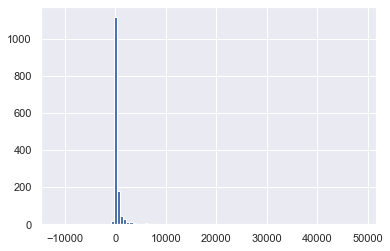

In [ ]:
Aj_US_ROF_exit_df['net_adj_return'].hist(bins=100)

In [ ]:
Aj_UK_ROF_exit_df = adjuested_investment_company_df(Deal_UK_ROF,Deal_UK_Exit,UK_compname)

In [ ]:
Aj_UK_ROF_exit_df.describe()

,exit_value,adjust_investment_amount,sum_invest_amount,net_adj_return,Time_to_exit,number_of_rounds,log_exit_value,log_adjust_investment_amount,log_sum_invest_amount,log_Time_to_exit,log_number_of_rounds
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,355.184643,60.106446,50.766875,295.078197,4.254868,1.437500,4.187672,2.483133,2.254523,1.096839,0.238805
std,748.904729,156.273697,141.394225,739.454081,3.581055,0.918099,2.101151,1.971002,1.976033,0.901824,0.445613
min,0.170000,0.010984,0.010000,-941.544407,0.109589,1.000000,-1.771957,-4.511333,-4.605170,-2.211018,0.000000
25%,15.282500,4.316469,3.455000,4.177821,1.865068,1.000000,2.726704,1.462438,1.239434,0.623298,0.000000
50%,60.400000,10.950627,8.860000,38.117130,3.234247,1.000000,4.097674,2.393397,2.181340,1.173660,0.000000
75%,412.760000,47.547360,37.045000,253.009247,5.521233,1.250000,6.022346,3.860123,3.612131,1.708595,0.173287
max,5489.030000,1147.954407,1089.060000,5391.669525,17.041096,6.000000,8.610507,7.045737,6.993070,2.835628,1.791759


### Relationship between the exit value and other variables

#### Checked dependent

##### Chi-square test for exit value and investment amount

In [ ]:
from scipy.stats import chi2_contingency
  
# defining the table

stat, p, dof, expected = chi2_contingency(Aj_US_ROF_exit_df[['exit_value','sum_invest_amount']])
  
# interpret p-value
alpha = 0.0005
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


In [ ]:
from scipy.stats import spearmanr

corr, pvalue = spearmanr(Aj_US_ROF_exit_df[['sum_invest_amount']], Aj_US_ROF_exit_df[['exit_value']])
print("p value is " + str(pvalue))

alpha = 0.05

if pvalue <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 8.084320403634569e-46
Dependent (reject H0)


##### spearmanr for exit value and exit time

In [ ]:

corr, pvalue = spearmanr(Aj_US_ROF_exit_df[['Time_to_exit']], Aj_US_ROF_exit_df[['exit_value']])
print("p value is " + str(pvalue))

alpha = 0.05

if pvalue <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 0.14275803605007126
Independent (H0 holds true)


In [ ]:
corr, pvalue = spearmanr(Aj_US_ROF_exit_df[['Time_to_exit']], Aj_US_ROF_exit_df[['sum_invest_amount']])
print("p value is " + str(pvalue))

alpha = 0.05

if pvalue <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.28184350336145586
Independent (H0 holds true)


#### Distribution for Time to exit

Text(0.5, 0, 'Time in years')

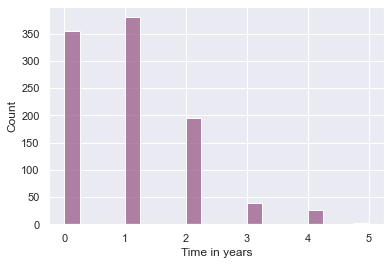

In [ ]:
# Generate 1000 random samples from the Poisson distribution
samples = np.random.poisson(1, 1000)
sns.histplot(samples,bins=20,color = sns.cubehelix_palette(8)[4])
plt.xlabel('Time in years')

Text(0.5, 0, 'Time in years')

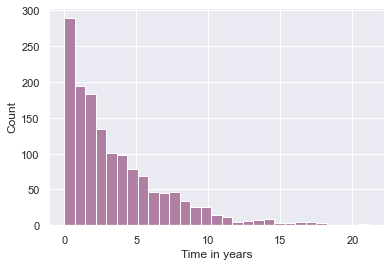

In [ ]:
sns.histplot(Aj_US_ROF_exit_df['Time_to_exit'],color = sns.cubehelix_palette(8)[4])
plt.xlabel('Time in years')

In [ ]:
dist = distfit()        # Initialize 
dist.fit_transform(Aj_US_ROF_exit_df['Time_to_exit'])

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.108179] [loc=3.620 scale=3.522]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.00338616] [loc=0.003 scale=3.618]
[distfit] >[pareto    ] [0.07 sec] [RSS: 0.0644202] [loc=-1.413 scale=1.416]
[distfit] >[dweibull  ] [0.06 sec] [RSS: 0.09123] [loc=2.890 scale=2.684]
[distfit] >[t         ] [0.08 sec] [RSS: 0.0859142] [loc=2.743 scale=2.345]
[distfit] >[genextreme] [0.19 sec] [RSS: 0.0286501] [loc=1.623 scale=1.679]
[distfit] >[gamma     ] [0.16 sec] [RSS: 0.00265045] [loc=0.003 scale=3.844]
[distfit] >[lognorm   ] [0.13 sec] [RSS: 0.015192] [loc=-0.251 scale=2.520]
[distfit] >[beta      ] [0.27 sec] [RSS: 0.00518843] [loc=0.003 scale=22.496]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.21954] [loc=0.003 scale=21.123]
[distfit] >[loggamma  ] [0.14 sec] [RSS: 0.110069] [loc=-770.052 scale=112.554]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.gamma_gen at 0x145ede40b80>,
  'stats': 'RSS',
  'params': (0.9522302061039518, 0.00273972602739726, 3.843688903786143),
  'name': 'gamma',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x145f072ee20>,
  'score': 0.0026504544187641523,
  'loc': 0.00273972602739726,
  'scale': 3.843688903786143,
  'arg': (0.9522302061039518,),
  'CII_min_alpha': 0.1683656821970469,
  'CII_max_alpha': 11.159159331819865},
 'summary':          distr     score  LLE         loc      scale  \
 0        gamma   0.00265  NaN     0.00274   3.843689   
 1        expon  0.003386  NaN     0.00274   3.617515   
 2         beta  0.005188  NaN     0.00274  22.495571   
 3      lognorm  0.015192  NaN   -0.251088   2.520146   
 4   genextreme   0.02865  NaN    1.623196   1.678742   
 5       pareto   0.06442  NaN   -1.413481    1.41622   
 6            t  0.085914  NaN    2.742974    2.34467   
 7     dweibull   0.09123  NaN    2.889654   2.683997   
 8  

In [ ]:
# dist = distfit(distr = 'lognorm',smooth = 10)        # Initialize 
# disfit_result_duration = dist.fit_transform(Aj_US_ROF_exit_df['Time_to_exit'])

In [ ]:
Time_to_exit_params = dist.model['params']
Time_to_exit_params

(0.9522302061039518, 0.00273972602739726, 3.843688903786143)

Text(0.5, 0, 'Time in years')

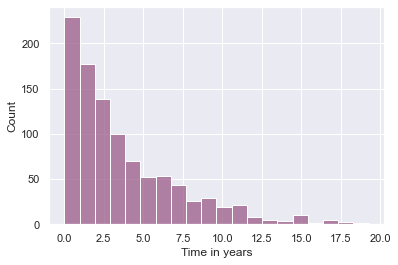

In [ ]:
samples = scipy.stats.gamma.rvs(Time_to_exit_params[0],loc=Time_to_exit_params[1],scale=Time_to_exit_params[2], size=1000)
sns.histplot(samples[samples < 20],bins=20,color = sns.cubehelix_palette(8)[4])
plt.xlabel('Time in years')

####  Exit value follows a jump-diffusion process

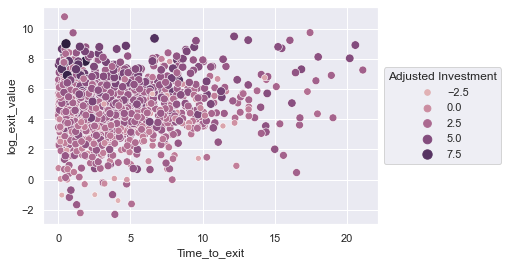

In [ ]:
g = sns.scatterplot(data=Aj_US_ROF_exit_df, x="Time_to_exit", y="log_exit_value", hue='log_adjust_investment_amount',size='log_adjust_investment_amount',sizes=(20, 100))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Adjusted Investment')

<AxesSubplot:xlabel='Time_to_exit', ylabel='log_exit_value'>

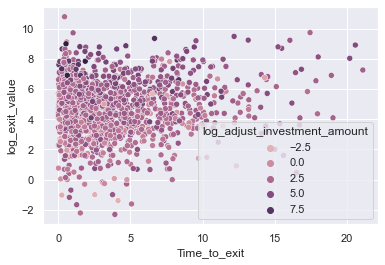

In [ ]:
sns.scatterplot(data=Aj_US_ROF_exit_df, x="Time_to_exit", y="log_exit_value", hue='log_adjust_investment_amount')

### Selection Model

#### Confirm the parameters value

In [ ]:
I = 20
K = 1000
Max_investment_length = 10 # In years
Number_of_rounds = 2 # suppose all invested in two rounds
Invest_per_round = 20 
Expacted_exit_value_per_company = 400

#### find minimum terminated round in each k

In [ ]:
# Investment

# Test of creating class
# class selection_problem():
#     def __init__(self, I=20, K=1000, Max_investment_length=10,Expacted_exit_value_per_company=3,duration_params = [3.1678816394371356, 2.742974039423639, 2.3446702170311653], adjust_invest_reg_params = [3.645460,0.462772,-0.491353]):
#         self.I = I #number of companies
#         self.K = K #number of iterations
#         self.Max_investment_length = Max_investment_length 
#         self.Expacted_exit_value_per_company = Expacted_exit_value_per_company
#         self.adjust_invest_reg_params = adjust_invest_reg_params # parameters fitted from regression
#         self.duration_params = duration_params
        
#     def k_times_terminated_rounds(self):
#         # Simulate completion time
# #         elements = [4,5,6,7,8]
# #         probabilities = [0.1,0.3,0.3,0.2,0.1]
# #         completion_time = np.random.choice(elements, self.I, p=probabilities)

#         completion_time_fra = scipy.stats.lognorm.rvs(self.duration_params[0],loc=self.duration_params[1],scale=self.duration_params[2], size=self.I)
#         completion_time_int = np.rint(completion_time_fra)
#         completion_time = np.array([i if i < Max_investment_length else Max_investment_length for i in completion_time_int])
        

#         rand_numbe_lognorm = scipy.stats.lognorm.rvs(self.params_exit_adjinvest[0],loc=self.params_exit_adjinvest[1],scale=self.params_exit_adjinvest[2], size=self.I)
#         # simulation: rand_numbe_lognorm = exit_value/sum_of_investment
#         sum_of_investment = (np.power(1.05,completion_time-1) - 1)/0.05 
        
#         exit_value_of_companies = rand_numbe_lognorm*sum_of_investment

        
#         sum_exit_return = 0
#         total_number_of_exit_companies = 0
#         for invest_rounds in range(self.Max_investment_length):
#             invest_each_round = np.power(1.05,invest_rounds)
#             for company_i in range(self.I):
#                 # Complete = reach completion rounds
#                 if invest_rounds >= completion_time[company_i]:
#                     # Only when net return>1 then we exit,or we terminate the investment in that company
#                     if ((exit_value_of_companies[company_i] - sum_of_investment[company_i]) > 1) & (invest_rounds == completion_time[company_i]):
#                         sum_exit_return = sum_exit_return + exit_value_of_companies[company_i] 
#                         total_number_of_exit_companies = total_number_of_exit_companies + 1
#                         #print('Company',company_i,'Finish at rounds',completion_time[company_i],':',exit_value_of_companies[company_i])
#                 # Not reaching completion rounds
#                 else:
#                     sum_exit_return = sum_exit_return - invest_each_round
#             if sum_exit_return > self.Expacted_exit_value_per_company*self.I:
#                 break

#         return invest_rounds,sum_exit_return,total_number_of_exit_companies
    
#     def k_times_terminated_rounds_resultDF(self):
#         investment_terminated_time = []
#         sum_of_return = []
#         n_comp = []
#         for k in range(self.K):
#             t,r,n = self.k_times_terminated_rounds()
#             investment_terminated_time.append(t)
#             sum_of_return.append(r)
#             n_comp.append(n)
#         selection_result_df = pd.DataFrame({'terminal_round':investment_terminated_time,'sum_of_return':sum_of_return,'number_of_exit_companies':n_comp})
#         return selection_result_df
    
#     def k_times_terminated_rounds_hist(self):
#         selection_result_df = self.k_times_terminated_rounds_resultDF()
#         plt.hist(selection_result_df.terminal_round)
#         plt.title('The investment rounds when portfoilo reaches the expected return {} for PE in {} simulation times'.format(self.I*self.Expacted_exit_value_per_company,self.K))
#         plt.xlabel('investment rounds')
#         plt.show()
    
#     def k_times_terminated_rounds_hist_sum_return(self):
#         selection_result_df = self.k_times_terminated_rounds_resultDF()
        
#         print(selection_result_df.groupby('terminal_round').agg({'sum_of_return':['mean', 'max', 'min','var']}))
        
#         selection_result_df['sum_of_return'].hist(by=selection_result_df['terminal_round'],figsize =(10,8))
#         plt.show()
        

In [ ]:
# First define the value you use I=20, K=1000, Max_investment_length=10,Expacted_exit_value_per_company=3,params=[1.8926501807066645, 0.0013935829239333539, 1.6564777495637903]
# test_1 = selection_problem()
# test_1_df = test_1.k_times_terminated_rounds_resultDF()
# test_1.k_times_terminated_rounds_hist()

#### Old method: Data simulation using regression

In [ ]:
# Older one 
class selection_problem_ARM_method():
    def __init__(self, I=20, K=500, Max_investment_length=20,Expacted_net_pro_ratio= 3,Time_to_exit_params= [0.9907360625882979, -0.2510879964450745, 2.5201460311724015],Invest_amount_params = [0.01, 48.55371267150928],adjust_invest_reg_params = [3.645460,0.462772,-0.491353],p=0.95):
        self.I = I #number of companies
        self.K = K #number of iterations
        self.Max_investment_length = Max_investment_length 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        self.Time_to_exit_params = Time_to_exit_params
        self.Invest_amount_params = Invest_amount_params
        self.adjust_invest_reg_params = adjust_invest_reg_params # parameters fitted for exit/investment return
        self.p = p
        
    def simu_k_scenairos(self):
# Simulate the completion time use disturbution 
# Simulate the investment amount use disturbution 
# Simulate the investment time use dist
# Simulate the exit value use regression result

#         elements = [4,5,6,7,8]
#         probabilities = [0.1,0.3,0.3,0.2,0.1]

        completion_time_Ktimes = []
        invest_amount_Ktimes = []
        invest_2_time_Ktimes = []
#         exit_value_Ktimes = []
#         sum_of_invest_Ktimes = []
        

        for k in range(self.K):
#             completion_time = np.random.choice(elements, self.I, p=probabilities)
#             completion_time_Ktimes.append(completion_time)
            
            completion_time_lognorm = scipy.stats.lognorm.rvs(self.Time_to_exit_params[0],loc=self.Time_to_exit_params[1],scale=self.Time_to_exit_params[2], size=self.I)
            completion_time_int = np.rint(completion_time_lognorm)
            completion_time = np.array([i if i < self.Max_investment_length else self.Max_investment_length for i in completion_time_int])
            completion_time_Ktimes.append(completion_time)
            
#             rand_numbe_lognorm = scipy.stats.lognorm.rvs(self.params[0],loc=self.params[1],scale=self.params[2], size=self.I)  
#             sum_of_investment = (np.power(1.05,completion_time-1) - 1)/0.05 
#             sum_of_investment_Ktimes.append(sum_of_investment)
            
#             invest_1 = scipy.stats.expon.rvs(self.Invest_amount_params[0],self.Invest_amount_params[1], size=self.I)
            invest_1 = np.repeat(10,self.I)
            invest_2 = invest_1 + (scipy.stats.binom.rvs(1, p=0.85,size=self.I) - 0.5)*10
        
            elements = [1.0,2.0,3.0,4.0,7.0,9.0]
            probabilities = [0.4,0.3,0.2,0.09,0.005,0.005]
            second_invest_time = np.random.choice(elements, self.I, p=probabilities)
            
#             # Make sure second investment time before the completion
#             for comp in rang(self.I):
#                 if second_invest_time[comp] > completion_time[comp]:
#                     second_invest_time[comp] = completion_time[comp]
            
            invest_amount_Ktimes.append(np.array([invest_1,invest_2]))
            invest_2_time_Ktimes.append(second_invest_time)

#             exit_value_of_companies = rand_numbe_lognorm*sum_of_investment
#             exit_value_of_companies_Ktimes.append(exit_value_of_companies)
        
            
#         completion_time_Ktimes = np.array(completion_time_Ktimes)
#         sum_of_investment_Ktimes = np.array(sum_of_investment_Ktimes)
#         exit_value_of_companies_Ktimes = np.array(exit_value_of_companies_Ktimes)
        
        completion_time_Ktimes = np.array(completion_time_Ktimes)
        invest_amount_Ktimes = np.array(invest_amount_Ktimes)
        invest_2_time_Ktimes = np.array(invest_2_time_Ktimes)
#         sum_of_invest_Ktimes = np.array(sum_of_invest_Ktimes)
#         exit_value_Ktimes = np.array(exit_value_Ktimes)
        

        return completion_time_Ktimes,invest_amount_Ktimes,invest_2_time_Ktimes
    
        

    def ARM_mini_investments_rounds(self):
    
        completion_time_Ktimes,invest_amount_Ktimes,invest_2_time_Ktimes= self.simu_k_scenairos()
        
        # Net return vetor --- Start with deducing the first investment 
        # Example: Investment_time = 2, I = 3, k = 4
        # x = np.array([[[2,3],[4,5],[4,7]],[[1,3],[4,5],[4,7]],[[2,4],[4,5],[4,7]],[[1,4],[4,5],[4,7]]])
        # np.sum(x,axis=1).T[0]
        sum_exit_return_list = np.zeros((self.K))
        
        # Company's status in the portfolio
        company_invest_status = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # Companies go though second round
        company_rounds = np.ones((self.K,self.I))
        
        for invest_rounds in range(self.Max_investment_length):
#             invest_each_round = np.power(1.05,invest_rounds)
            beta = 0 # number of simulation when the sum of return > threshold
    # Every round calculate a new sum 
            sum_exit_return_list = -np.sum(invest_amount_Ktimes,axis =1).T[0] * np.power(1.05,invest_rounds)
            sum_investment_list = np.sum(invest_amount_Ktimes,axis =1).T[0] * np.power(1.05,invest_rounds)
            
            for k in range(self.K):
                for company_i in range(self.I):
                    
                    # Suppose 25% company failed
#                     failed_comp = np.random.randint(self.I, size=5)
                    
                    # Second investment --- time & company no exit
                    if (invest_rounds >= invest_2_time_Ktimes[k][company_i]) & (company_invest_status[invest_rounds][k][company_i] == 0):
                        company_rounds[k][company_i] = 2
                        sum_exit_return_list[k] = sum_exit_return_list[k] - invest_amount_Ktimes[k][1][company_i]* np.power(1.05,invest_rounds - invest_2_time_Ktimes[k][company_i])
                        sum_investment_list[k] = sum_investment_list[k] + invest_amount_Ktimes[k][1][company_i]* np.power(1.05,invest_rounds - invest_2_time_Ktimes[k][company_i])
                    
                    # Complete = reach completion rounds ( exit or give up)
                    if invest_rounds >= completion_time_Ktimes[k][company_i]:
                        company_invest_status[invest_rounds][k][company_i] = 1
                        
                        # Number of rounds company go through
                        if company_rounds[k][company_i] == 2:
                            # Calulate the adj investment
                            adj_invest = invest_amount_Ktimes[k][0][company_i]*np.power(1.05,invest_rounds) + invest_amount_Ktimes[k][1][company_i]*np.power(1.05,invest_rounds-invest_2_time_Ktimes[k][company_i])
                            exit_value = np.exp(self.adjust_invest_reg_params[0] + self.adjust_invest_reg_params[1]*np.log(adj_invest) + self.adjust_invest_reg_params[2]*np.log(2))
                        else:
                            adj_invest = invest_amount_Ktimes[k][0][company_i]*np.power(1.05,invest_rounds)
                            exit_value = np.exp(self.adjust_invest_reg_params[0] + self.adjust_invest_reg_params[1]*np.log(adj_invest))
                        
                        # If company failed 
#                         if company_i in failed_comp:
#                             exit_value = 0
                        
                        # Exit > Invest then Success Exit
                        if exit_value > adj_invest:
                            sum_exit_return_list[k] = sum_exit_return_list[k] + exit_value
                        
                        
                if sum_exit_return_list[k]/sum_investment_list[k] > self.Expacted_net_pro_ratio:
                    beta = beta + 1
            if beta >= self.K*self.p:
                break

        return invest_rounds
    
    def ARM_repeat_robust_experiment(self,repeat_times):
        repeat_result = [self.ARM_mini_investments_rounds() for i in range(repeat_times)]
        
        return repeat_result,np.mean(np.array(repeat_result))

1. Define parameters:
- I name of companies -- 20
- ！！K scenairos -- 500-1000 \\
- T maximum investment length --- 10 years
- ！！ p risk acceptability --- 0.05
- In investment amount --- 20 per investment 

2. Generate prediction for 
- Exit Time --- Gamma disturbution --- two parameters
- Time for funding/investment --- every 2 year --- average 1.8  

- Exit value --- log normal, time decides by Time to exit + 60% failure rate ?

3. Experiment 
- input:  Parameters in 1 and for 2
- output: descion matrix y + termiated round 

4. Parameters to compare
- p risk acceptibility

#### Firm value: Geo brownian model

In [ ]:
def merton_paths(S=58, T=10, r=0.02, sigma=0.5, steps=100, Npaths=10):
    size=(steps,Npaths)
    dt = T/steps 
    geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo)*S

In [ ]:
def geo(S=58, T=10, r=0.02, sigma=0.5, steps=100, Npaths=10):
    size=(steps,Npaths)
    dt = T/steps 
    geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    
    return geo

Text(0, 0.5, 'Firm value')

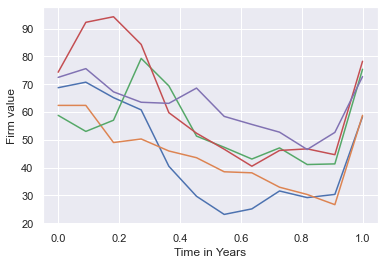

In [ ]:
S = 58 # inital firm value
T = 1 # time to maturity in years
r = 0.025 + 0.01  # risk free rate + PE positive effect
steps = 12 # time steps
Npaths = 5 # number of paths to simulate
sigma = 0.5 # following Cochrane (2005), Metrick and Yasuda (2010a), and Gornall and Strebulaev (2020).

j1 = merton_paths(S, T, r, sigma, steps, Npaths)
j1[-1] = j1[-1]+30

x = np.linspace(0,T,steps)
plt.plot(x,j1)
plt.xlabel('Time in Years')
plt.ylabel('Firm value')

In [ ]:
j1[-1] + np.log(30)/j1[-1]

array([58.37234023, 58.84549984, 75.41209404, 78.28219581, 72.77389698])

In [ ]:
np.exp(j1[-1])*S*(1+30/S)

array([1.86181902e+27, 2.98973123e+27, 4.74176392e+34, 8.37777464e+35,
       3.38434087e+33])

#### Current Method: miminmum investment time 95% in k simulations

Assumption that cannot be replicated in stock portfolio management:
1. The jump increment for the price prediction
2. Exit time -- Investment terminal time is randomly predefined (only at the exit time it generate profit) 
- This means that even if the firm value is high, we cannot calculate the value into the portfolio if it haven't exit yet.

My model --- Conditions whether in the porfolio:
1. same position all investers in the beginning 
2. simulate 1000 firm increase.

Conditions for whether invest:
1. use the mean/cov of simulation & markowitz for the investment descision 
2. the upper/ lower boundary for firm value 

In [ ]:
# Revised one
class selection_problem_ARM_method_revise():
    def __init__(self, I=20, K=500, Max_investment_length=20,Expacted_net_pro_ratio=3,Time_to_exit_params=[0.952, 0.00273, 3.843],p=0.95):
        self.I = I #number of companies
        self.K = K #number of iterations
        self.Max_investment_length = Max_investment_length 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        self.Time_to_exit_params = Time_to_exit_params
        self.p = p
        
    def simu_k_scenairos(self):
        completion_time_Ktimes = []

        for k in range(self.K):

            completion_time_lognorm = scipy.stats.gamma.rvs(self.Time_to_exit_params[0],loc=self.Time_to_exit_params[1],scale=self.Time_to_exit_params[2], size=self.I)
            completion_time = np.rint(completion_time_lognorm)
            completion_time_Ktimes.append(completion_time)
        
        completion_time_Ktimes = np.array(completion_time_Ktimes)
        

        return completion_time_Ktimes
    
    # np.exp(geo)*S0
    
    def fimevalue_increase(self):
        size= 12
        dt = 1/12 
        r,sigma = 0.02, 0.5
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
        return geo[-1]
        
    def ARM_mini_investments_rounds(self):
    
        completion_time_Ktimes= self.simu_k_scenairos()
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # random var: Company's firm value
        firm_value_increase = np.zeros((self.K,self.I,self.Max_investment_length))
        
        # Investment in each round
        invest_each_round = [10,20,30]
        
        #Exercise boundary for firm value
        exer_boundary = [[38.56,36.64,35,33.5,32,31,30,29,28,27],
                 [38.56,36.64,35,33.5,32,31,30,29,28,27]]
        
        # Number of rounds of investment companies go though 
        company_rounds = np.ones((self.K,self.I))
        
        # Sum of investment
        sum_investment_list = np.full(self.K,invest_each_round[0])
        
        # Sum of return
        sum_exit_return_list = np.zeros(self.K)
        
        number_company_exit = np.zeros(self.K)
        
        # Sum of measure
        mDPI = np.zeros(self.K)
        
        success = 0
        for t in range(1,self.Max_investment_length):

            beta = 0 # number of simulation when the sum of return > threshold
    
            for k in range(self.K):
            
                for company_i in range(self.I):

                    
                    # Check if company is still in portfolio
                    if company_invest_status[t][k][company_i]== 0:
                        firm_value_increase[k][company_i][t] = self.fimevalue_increase()
                        
                        # Complete = reach completion rounds 
                        if t == completion_time_Ktimes[k][company_i]:
                            company_invest_status[t][k][company_i] = 1
                            
                            # firm value at exit + investment 
                            exit_value = np.exp(np.sum(firm_value_increase[k][company_i][:t]))*58 #+ company_rounds[k][company_i]*10
                            
                            # Add the terminated firm value
                            sum_exit_return_list[k] = sum_exit_return_list[k] + exit_value
                            # All later rounds firms status = 1
                            company_invest_status[t:,k,company_i] = np.ones((self.Max_investment_length-t))
                                    
                        # For company still in the portfolio and need investment
                        elif (company_rounds[k][company_i] != 3):
                            for invest_rounds in [1,2]:
                                firm_value = np.exp(np.sum(firm_value_increase[k][company_i][t:]))*58 
                                # check rounds and firm value 
                                if (company_rounds[k][company_i] == invest_rounds) & (np.sum(firm_value,axis=0) > exer_boundary[invest_rounds-1][t-1]):
                                    
                                    company_rounds[k][company_i] = invest_rounds + 1
                                    firm_value_increase[k][company_i][t] = firm_value_increase[k][company_i][t] * (company_rounds[k][company_i]+0.9)
                                    
                                    sum_investment_list[k] = sum_investment_list[k] + invest_each_round[invest_rounds]
                        
                        
                if sum_exit_return_list[k]/sum_investment_list[k] > self.Expacted_net_pro_ratio:
                    beta = beta + 1
                    mDPI[k] = sum_exit_return_list[k]/sum_investment_list[k]
                    number_company_exit[k] = np.sum(company_invest_status[t][k][:])
                    
            if beta >= self.K*self.p:
                success = 1
                return t,np.quantile(mDPI,1-self.p),np.mean(number_company_exit)
                break 
        if (t == self.Max_investment_length-1) & (success == 0):
            #print('Not reachable',beta)
            return np.nan,np.nan,np.mean(number_company_exit)
        
    
    def ARM_repeat_robust_experiment(self,repeat_times):
        repeat_result_t_list = []
        repeat_result_R_star_list = []
        repeat_num_comp_list = []
        for i in range(repeat_times):
            repeat_result_t,repeat_result_R_star,repeat_num_comp = self.ARM_mini_investments_rounds()
            repeat_result_t_list.append(repeat_result_t)
            repeat_result_R_star_list.append(repeat_result_R_star)
            repeat_num_comp_list.append(repeat_num_comp)
        
        nan_count = np.sum(np.isnan(repeat_result_t_list))
        
        if nan_count > repeat_times*0.2:
            return np.nan,np.nan,np.mean(repeat_num_comp_list)
        else:
            return np.nanmean(repeat_result_t_list),np.nanmean(repeat_result_R_star_list),np.mean(repeat_num_comp_list)

In [ ]:
test_ARM_revised = selection_problem_ARM_method_revise(Expacted_net_pro_ratio = 3,p=0.99)
test_ARM_revised.ARM_mini_investments_rounds()

(16, 3.0337386720158572, 16.888)

In [ ]:
test_ARM_revised.ARM_repeat_robust_experiment(10)

(nan, nan, 16.8568)

##### Robust test for repeat from 10 to 200; k from 100 to 1000

In [ ]:
repeat_test_times = np.arange(5,50,5,dtype=int)
robust_test_repet_df = pd.DataFrame(index = repeat_test_times)

In [ ]:
for R in [3,4,5]:   
    robust_test_repet = []
    for repeat_time in repeat_test_times:
        dif_k_test_result = selection_problem_ARM_method_revise(Expacted_net_pro_ratio=R)
        difk_avg_result = dif_k_test_result.ARM_repeat_robust_experiment(repeat_time)
        robust_test_repet.append(np.mean(np.array(difk_avg_result)))
    robust_test_repet_df[R] = np.array(robust_test_repet)

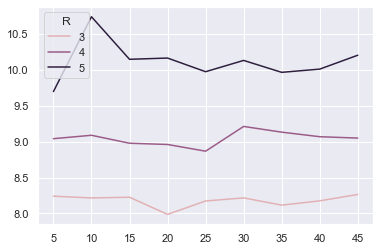

In [ ]:
sns.set()
robust_test_repet_df.plot(color = [sns.cubehelix_palette(8)[1],sns.cubehelix_palette(8)[4],sns.cubehelix_palette(8)[7]])
plt.legend(title='R')

In [ ]:
# d = {'R':np.repeat(np.array([3,3.5,4]), 12),'Repeated time':np.tile(np.array(np.arange(0,60,5, dtype=int)), 3),'Terminated Rounds': [1.5,1.7,1.2,1.4,1.3,1.5,1.2,1.3,1.4,1.2,1.3,1.3,2.5,2.8,3.2,3.1,2.7,3.4,2.9,2.75,2.8,2.6,2.7,2.7,4.3,4.9,5.2,4.1,4.5,4.6,4.9,4.75,4.83,4.85,4.79,4.81]}
# Test_result = pd.DataFrame(data=d)
# fig, ax = plt.subplots()
# sns.lineplot(data=Test_result,y='Terminated Rounds',x='Repeated time',hue='R')

In [ ]:
# d = {'R':np.repeat(np.array([3,3.5,4]), 12),'K':np.tile(np.array(np.arange(0,60,5, dtype=int)), 3),'Terminated Rounds': [1.5,1.6,1.2,1.4,1.35,1.4,1.29,1.31,1.34,1.31,1.36,1.35,2.5,2.8,3.2,3.1,2.7,2.95,2.9,2.75,2.73,2.68,2.7,2.7,4.3,4.5,5.1,4.8,4.5,4.6,4.9,4.75,4.83,4.85,4.79,4.81]}
# Test_result = pd.DataFrame(data=d)
# fig, ax = plt.subplots()
# sns.lineplot(data=Test_result,y='Terminated Rounds',x='K',hue='R')

##### Result for different expected payoff and p-value

In [ ]:
# R_expected = [10,30,50,70,90,100]
# p_value = [0.1,0.5,0.8,0.95]
# ARM_simreg_result = pd.DataFrame({'Expected Net Return':R_expected})
# terminated_rounds = []
# for p_v in p_value:
#     for r in R_expected:
#         test_result = selection_problem_ARM_method(Expacted_net_pro_rao_per_company= r, p = p_v)
#         terminated_rounds.append(test_result.ARM_mini_investments_rounds())

In [ ]:
Ratio_expected = [3.0,5.0,7.0,8.0,9.0,10,11,12,13,14,15]
p_value = [0.5]
repeat_times = 10
ARM_simreg_result = pd.DataFrame({'Expected Net Return Ratio':Ratio_expected})
terminated_rounds = []
max_payoff_ratio=[]
num_comp = []
for p_v in p_value:
    for r in Ratio_expected:
        test_result_t = selection_problem_ARM_method_revise(Expacted_net_pro_ratio= r, p = p_v)
        avg_result_t,avg_result_R,avg_result_num_comp = test_result_t.ARM_repeat_robust_experiment(repeat_times)
        terminated_rounds.append(avg_result_t)
        max_payoff_ratio.append(avg_result_R)
        num_comp.append(avg_result_num_comp)

In [ ]:
ARM_simreg_result = pd.DataFrame({'Expected Net Payoff Ratio':np.tile(Ratio_expected,len(p_value)),
                                 'p-value':np.repeat(p_value,len(Ratio_expected)),
                                 'Terminated Rounds of the Fund':terminated_rounds,
                                 'Maximun Payoff Ratio':max_payoff_ratio,
                                 'Number of Companies Successfully Exit':num_comp})

In [ ]:
ARM_simreg_result

,Expected Net Payoff Ratio,p-value,Terminated Rounds of the Fund,Maximun Payoff Ratio,Number of Companies Successfully Exit
0,3.0,0.9,5.3,4.102253,12.1740
1,5.0,0.9,6.3,6.635970,12.9612
2,7.0,0.9,7.2,8.490035,13.5924
3,8.0,0.9,7.6,9.058091,13.6296
4,9.0,0.9,8.2,10.049000,13.9206
5,10.0,0.9,9.2,10.498754,14.2480
6,11.0,0.9,9.3,11.734817,14.3866
7,12.0,0.9,10.9,12.006976,14.6218
8,13.0,0.9,NaN,NaN,14.9642
9,14.0,0.9,NaN,NaN,14.9532


Text(0, 0.5, 'Maximum Payoff')

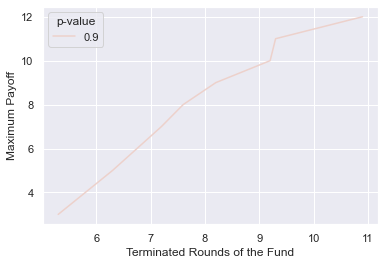

In [ ]:
sns.lineplot(data=ARM_simreg_result,y='Expected Net Payoff Ratio',x='Terminated Rounds of the Fund',hue='p-value')
plt.ylabel('Maximum Payoff')

<AxesSubplot:xlabel='Expected Net Payoff Ratio', ylabel='Terminated Rounds of the Fund'>

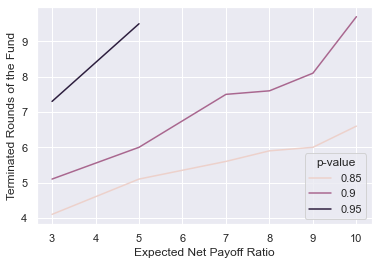

In [ ]:
sns.lineplot(data=ARM_simreg_result,x='Expected Net Payoff Ratio',y='Terminated Rounds of the Fund',hue='p-value')

(4.0, 14.0)

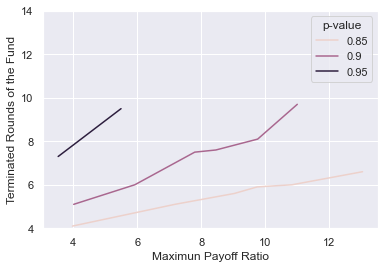

In [ ]:
sns.lineplot(data=ARM_simreg_result,x='Maximun Payoff Ratio',y='Terminated Rounds of the Fund',hue='p-value')
plt.ylim((4,14))

### Additional coding

#### Jump Diffusion for exit value

$dX_t = X_t(r_f +\alpha)dt + X_t \sigma dW_t + I_i dN_t$

In [ ]:
def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S

Text(0, 0.5, 'Firm Value')

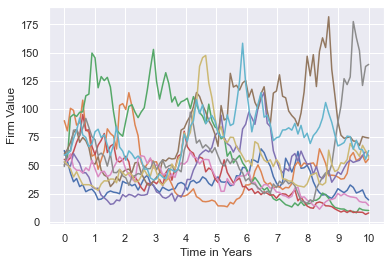

In [ ]:
S = 58 # current stock price
T = 5 # time to maturity
r = 0.035 # risk free rate
m = 0.2 # meean of jump size
v = 0 # standard deviation of jump
lam = 4 # intensity of jump i.e. number of jumps per annum
steps = 100 # time steps
Npaths = 10 # number of paths to simulate
sigma = 0.5 # annaul standard deviation , for w
j = merton_jump_paths(S, T, r, sigma, lam, m,v, steps, Npaths)
x = np.linspace(0,10,steps)

plt.plot(x,j)
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Time in Years')

plt.ylabel('Firm Value')

##### BS Call price

In [ ]:
def bs_price(S, K, T, r, sigma, call=True):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if call:
        return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [ ]:
# T1 = 0 T2 =1 T3 = 3
T = 2    # T2 - T1
S0 = 36.64 # firm value at t1
K =  20   # K_2
r = 0.05   # risk-free interest rate

# Model parameter
sigma = 0.5 # volatility

C_bs = bs_price(S0, K, T, r, sigma, call=True) # When S0 > V*=39, C_bs > K_1=20 
C_bs

20.008130859868974

In [ ]:
from scipy.optimize import fsolve

def f(S0,*args):
    K,T,r,sigma,optionPrice=args
    return bs_price(S0,K,T,r,sigma,True)-optionPrice

K,T,r,sigma= 20,1,0.03,0.5
optionPrice = 20
impliedS0=fsolve(f,x0=30,args=(K,T,r,sigma,optionPrice))[0]
impliedS0

38.9060562685032

#### Disturbution for investment amount

In [ ]:
np.median(Deal_US_ROF['Total Transaction Value ($M)'])

11.0

In [ ]:
dist = distfit()
dist.fit_transform(Deal_US_ROF['Total Transaction Value ($M)'])

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 2.65718e-05] [loc=48.564 scale=286.948]
[distfit] >[expon     ] [0.00 sec] [RSS: 3.95467e-06] [loc=0.010 scale=48.554]
[distfit] >[pareto    ] [0.07 sec] [RSS: 2.65546e-05] [loc=-3.246 scale=3.256]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 2.98488e-05] [loc=7.000 scale=14.596]
[distfit] >[t         ] [0.04 sec] [RSS: 3.41945e-05] [loc=8.799 scale=6.639]
[distfit] >[genextreme] [0.08 sec] [RSS: 3.83354e-05] [loc=4.215 scale=3.745]
[distfit] >[gamma     ] [0.07 sec] [RSS: 4.07468e-05] [loc=0.010 scale=4.001]
[distfit] >[lognorm   ] [0.05 sec] [RSS: 2.25982e-05] [loc=-0.250 scale=11.908]
[distfit] >[beta      ] [0.09 sec] [RSS: 1.35785e-05] [loc=0.010 scale=85882.446]
[distfit] >[uniform   ] [0.0 sec] [RSS: 3.98579e-05] [loc=0.010 scale=7499.990]
[distfit] >[loggamma  ] [0.05 sec] [RSS: 2.80101e-05] [loc=-81718.777 scale=11451.149]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.expon_gen at 0x18111a9f3d0>,
  'stats': 'RSS',
  'params': (0.01, 48.55371267150928),
  'name': 'expon',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x18114424ac0>,
  'score': 3.9546719850134356e-06,
  'loc': 0.01,
  'scale': 48.55371267150928,
  'arg': (),
  'CII_min_alpha': 2.500479877668268,
  'CII_max_alpha': 145.46392405090765},
 'summary':          distr     score  LLE           loc         scale  \
 0        expon  0.000004  NaN          0.01     48.553713   
 1         beta  0.000014  NaN          0.01  85882.445656   
 2      lognorm  0.000023  NaN      -0.24974     11.907734   
 3       pareto  0.000027  NaN     -3.245709      3.255709   
 4         norm  0.000027  NaN     48.563713    286.947626   
 5     loggamma  0.000028  NaN -81718.776772  11451.148763   
 6     dweibull   0.00003  NaN           7.0     14.596162   
 7            t  0.000034  NaN      8.798908      6.639349   
 8   genextreme  0.000038  N

#### TIme between rounds

In [ ]:
Deal_US_ROF.Round_diff.hist(bins = 30)

In [ ]:
elements = [0.5,1.0,1.5,2.0,3.0,4.0,5.0,8.0,10.0]
probabilities = [0.2,0.3,0.25,0.15,0.06,0.03,0.005,0.005]


#### Disturbution for Exit value/ adjuested investment amount

In [ ]:
dist = distfit(distr = 't',smooth = 10)        # Initialize 
disfit_result_exit_adj_invest = dist.fit_transform(Aj_US_ROF_exit_df['exit_value']/Aj_US_ROF_exit_df['adjust_investment_amount'] )

exit_divid_adj_invest_params = dist.model['params']
exit_divid_adj_invest_params

In [ ]:
Exit_adj_invest_params = dist.model['params']
Exit_adj_invest_params

In [ ]:
test_rand_exit_aj = scipy.stats.lognorm.rvs(Exit_adj_invest_params[0],loc=Exit_adj_invest_params[1],scale=Exit_adj_invest_params[2], size=10)
test_rand_exit_aj

#### Parameters for the Model --- the failure rate 25% company cannot complete in + 10 years 50% company 0 return 

In [ ]:
firmvalue = np.zeros((10,20))
firmvalue[1]

In [ ]:
exer_boundary = [[38.56,36.64,35,33.5,32,31,30,29,28,27],
                 [38.56,36.64,35,33.5,32,31,30,29,28,27]]

In [ ]:
exer_boundary[0][0]

In [ ]:
def GEM_value(s0=50,t=1):
    mu,sigma = 0.02,0.5
    GEM = s0*np.exp((mu-sigma**2)*t + sigma*np.random.normal(0,np.sqrt(t)))
    
    return GEM

In [ ]:
I = 20
Max_investment_length = 10
S0 = 58
# investment amount for each round 
invest_amount = [20,20,30]
# exercise boundary for current firm value at different time (from t =1) 
exer_boundary = [[38.56,36.64,35,33.5,32,31,30,29,28],
                 [38.56,36.64,35,33.5,32,31,30,29,28]]
                 


# firmvalue = np.zeros((T,I))
# firm value after the first year & first round
firmvalue = np.array([GEM_value(s0,1) for x in range(I)]) 
# rounds done for company i
round_done = np.ones(I)
# investment period for each company 
completion_time_gamma = scipy.stats.gamma.rvs(Time_to_exit_params[0],loc=Time_to_exit_params[1],scale=Time_to_exit_params[2], size=I)
completion_time_int = np.rint(completion_time_gamma)
completion_time_Ktimes.append(completion_time)

invest_total = 0

for t in range(2,Max_investment_length):
    for i in range(len(firmvalue)):
        # check whether go through second investment 
        if (round_done[i] == 1) & firmvalue[i]> exer_boundary[0][t-2] :
            # firm value growth add invest amount 
            firmvalue[i] = GEM_value(firmvalue[i]+investment[round_done[i]],t)
            # investment total add investment 
            invest_total = invest_total + invest_amount[1]
            round_done[i] = 2
            # check whether go through the third round
        elif round_done[i] == 2 & firmvalue[i] > exer_boundary[1][t-2] :
            firmvalue[i] = GEM_value(firmvalue[i]+investment[round_done[i]],t)
            # investment total add investment 
            invest_total = invest_total + invest_amount[1]
            round_done[i] = 3
            

        
    # Threshold 39 for investment 20 in 2 years
firmvalue = [i+20 if i>39 else i for i in firmvalue] # Right after second run


#### Result : Resgression result for log_exit_value ~ log_adjust_investment_amount +  number_of_rounds

In [ ]:
adjust_invest_result = sm.ols(formula="log_exit_value ~ log_adjust_investment_amount + log_number_of_rounds", data=Aj_US_ROF_exit_df).fit()
print(adjust_invest_result.summary())

                            OLS Regression Results                            
Dep. Variable:         log_exit_value   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     124.1
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           1.83e-50
Time:                        03:18:57   Log-Likelihood:                -2787.6
No. Observations:                1450   AIC:                             5581.
Df Residuals:                    1447   BIC:                             5597.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
adjust_invest_result.params

Intercept                       3.645460
log_adjust_investment_amount    0.462772
log_number_of_rounds           -0.491353
dtype: float64

In [ ]:
adjust_invest_reg_params = adjust_invest_result.params = [3.645460,0.462772,-0.491353]

##### Result : Resgression result for log_exit_value ~ log_investment_amount + number_of_rounds

In [ ]:
nonadjust_invest_result = sm.ols(formula="log_exit_value ~ log_sum_invest_amount + log_number_of_rounds", data=Aj_US_ROF_exit_df).fit()
print(nonadjust_invest_result.summary())

                            OLS Regression Results                            
Dep. Variable:         log_exit_value   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     121.3
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           2.02e-49
Time:                        03:18:57   Log-Likelihood:                -2790.0
No. Observations:                1450   AIC:                             5586.
Df Residuals:                    1447   BIC:                             5602.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.73

In [ ]:
nonadjust_invest_result.params

Intercept                3.736555
log_sum_invest_amount    0.459687
log_number_of_rounds    -0.455649
dtype: float64

In [ ]:
##### Result : Resgression result for log_exit_value ~ log_investment_amount + number_of_rounds

In [ ]:
# Market parameters
T = 1      # maturity
S0 = 1     # spot price
K = 1.1    # strike price
r = 0.05   # risk-free interest rate
q = 0.02   # dividend rate

# Model parameter
sigma = 0.4 # volatility

# Model parameters for the jump part
mu_j = -0.1
sigma_j = 0.15
lmbda = 0.5

# Call value
Vc = merton_jump_analytical(S0, K, T, r, q, sigma, mu_j, sigma_j, lmbda, call=True, max_iter=100, stop_cond=1e-15)

# # Put value
# Vp = merton_jump_analytical(S0, K, T, r, q, sigma, mu_j, sigma_j, lmbda, call=False, max_iter=100, stop_cond=1e-15)

print('Call price: ' + str(round(Vc, 4)))
# print('Put price:  ' + str(round(Vp, 4)))


NameError: name 'merton_jump_analytical' is not defined

In [ ]:
Invest_amount_params = dist.model['params']
Invest_amount_params

(0.01, 48.55371267150928)

In [ ]:
test_rand_exit_aj = scipy.stats.expon.rvs(Invest_amount_params[0],Invest_amount_params[1], size=10)
np.median(test_rand_exit_aj)

39.130413850376634

In [ ]:
nonadjustlog_invest_result = sm.ols(formula="log_exit_value ~ log_sum_invest_amount + number_of_rounds", data=Aj_US_ROF_exit_df).fit()
print(nonadjustlog_invest_result.summary())

                            OLS Regression Results                            
Dep. Variable:         log_exit_value   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     113.0
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           2.56e-46
Time:                        03:19:37   Log-Likelihood:                -2797.2
No. Observations:                1450   AIC:                             5600.
Df Residuals:                    1447   BIC:                             5616.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.85

#### Linear relationship: Exit value  ~ adj investment amount + number of rounds 

[Text(0.5, 1.0, 'Correlation Matrix')]

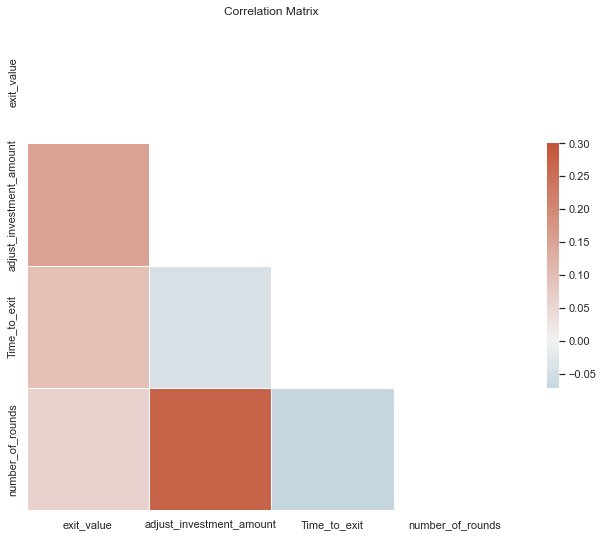

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = Aj_US_ROF_exit_df[['exit_value','adjust_investment_amount','Time_to_exit','number_of_rounds']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Correlation Matrix')

[Text(0.5, 1.0, 'Correlation Matrix')]

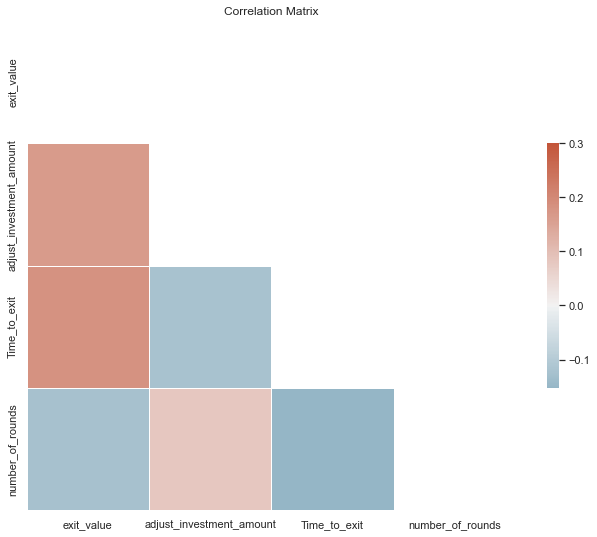

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = Aj_UK_ROF_exit_df[['exit_value','adjust_investment_amount','Time_to_exit','number_of_rounds']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Correlation Matrix')

In [ ]:
# Exit value uncorrlated with investment length 
# corr_duration, _ = pearsonr(reg_US_ROF_exit_df['exit_value'], reg_US_ROF_exit_df['duration'])
# print('Pearsons correlation: %.3f' % corr_duration)

In [ ]:
# corr_duration_UK, _ = pearsonr(reg_UK_ROF_exit_df['exit_value'], reg_UK_ROF_exit_df['duration'])
# print('Pearsons correlation: %.3f' % corr_duration_UK)

In [ ]:
# corr_investamount, _ = pearsonr(reg_US_ROF_exit_df['exit_value'], reg_US_ROF_exit_df['adjust_investment_amount'])
# print('Pearsons correlation: %.3f' % corr_investamount)

In [ ]:
# corr_numb_of_rounds, _ = pearsonr(reg_US_ROF_exit_df['exit_value'], reg_US_ROF_exit_df['number_of_rounds'])
# print('Pearsons correlation: %.3f' % corr_numb_of_rounds)